https://github.com/andrewrgarcia/XRDpy/blob/master/XRD_functions.py

# detect peak version

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy import signal
from scipy.optimize import curve_fit
import pylab as pl

# pip install xrayutilities
import numpy as np
import xrayutilities as xu
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_exp_curves(X, Ys, labels, diff=1e3, marker=None, title=None, save_path=None):
    X = np.copy(X).reshape(-1)
    fig, axes = plt.subplots(figsize=(18, 6+(len(Ys)-1)*2))
    for i, Y in enumerate(Ys):
        Y[Y==0] = 1  # remove all 0 value
        Y = Y * diff**(len(Ys)-i-1)
        axes.plot(X, Y, marker=marker, label=labels[i])
        
    axes.set_xlabel(r"2$\Theta}$", )
    axes.set_ylabel('Intensity [a.u.]')
    axes.legend()
    plt.yscale('log',base=10) 
    plt.title(title)
    
    if save_path:
        plt.savefig(save_path, dpi=1200)
    plt.grid()
    plt.show()
    
def plot_xrd(files, labels, title='XRD result', diff=1e3, save_path=None, marker=None, pad_sequence=[]):
    Xs, Ys = [], []
    length_list = []
    for file in files:
        out = xu.io.getxrdml_scan(file)
        Xs.append(out[0])
        Ys.append(out[1])
        length_list.append(len(out[0]))
        
    if np.mean(length_list) != np.max(length_list):
        if pad_sequence == []:
            print('Different scan ranges, input pad_sequence to pad')
            return 
        else:
            for i in range(len(Ys)):
                Ys[i] = np.pad(Ys[i], pad_sequence[i], mode='median')
    X = Xs[np.argmax(length_list)]
    plot_exp_curves(X, Ys, labels, diff, marker, title, save_path)

def gaussfit(xdata,ydata):
    meanest = xdata[ydata.index(max(ydata))]
    sigest = meanest - min(xdata)
#    print('estimates',meanest,sigest)
    popt, pcov = optimize.curve_fit(funcgauss,xdata,ydata,p0 = [min(ydata),max(ydata),meanest,sigest], maxfev=50000)
#     print('-Gaussian fit results-')
# #    print('amplitude {}\nmean {}\nsigma {}'.format(*popt))
#     print('y-shift {}\namplitude {}\nmean {}\nsigma {}'.format(*popt))

#     print('covariance matrix \n{}'.format(pcov))
# #    print('pcov',pcov)
    return popt
    
    
'''Gaussian fit for FWHM'''
def funcgauss(x,y0,a,mean,sigma):
    return y0+(a/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mean)**2/(2*sigma*sigma))

#def funcgauss(x,y0,a,mean,fwhm):
#    return y0 + (a/(fwhm*np.sqrt(np.pi/(4*np.log(2)) )))*np.exp(-(4*np.log(2))*(x-mean)**2/(fwhm*fwhm))

'''Scherrer equation'''
def scherrer(K,lmda,beta,theta):
    return K*lmda / (beta*np.cos(theta))    #tau

def thickness(xseg, yseg, lambdaKa):
    y0,a,mean,sigma = gaussfit(xseg,yseg)
    ysegfit = funcgauss(np.array(xseg),y0,a,mean,sigma)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    axes[0].plot(xseg, yseg)
    axes[0].semilogy()
    axes[1].plot(xseg, ysegfit)
    axes[1].semilogy()
    plt.show()
    
    'FULL WIDTH AT HALF MAXIMUM'
    FWHM_deg = sigma*2*np.sqrt(2*np.log(2))
    FWHM = FWHM_deg*np.pi/180
#     print('\nFWHM == sigma*2*sqrt(2*ln(2)): {} degrees'.format(FWHM_deg))

    'scherrer width peak calculations'
    max_twotheta = xseg[list(yseg).index(max(yseg))]

    theta=max_twotheta/2
    theta=theta*np.pi/180

#     print('K (shape factor): {}\nK-alpha: {} nm \nmax 2-theta: {} degrees'.\
#           format(K,lambdaKa,max_twotheta))
    
    s=scherrer(K,lambdaKa,FWHM,theta)
    return s


def xrd_thickness(x, y, K, lambdaKa, xrange, n_peaks=5, show=False):
    # get the data in xrange
    x_in_range, y_in_range = [],[]
    for n in x:
        if n >= xrange[0] and  n <= xrange[1]:
            x_in_range.append(n)
            y_in_range.append(y[list(x).index(n)])

    
    # seperate all curves
    dist = len(y_in_range)/(n_peaks-1+3)
    print(x_in_range[int(dist)]-x_in_range[0])
    y_in_range_filtered = -np.log(y_in_range)
    peaks, properties = signal.find_peaks(y_in_range_filtered, prominence=0.2, distance=dist)

    xseg_list, yseg_list = [], []
    for i in range(len(peaks[:-1])):
        xseg_list.append(x_in_range[peaks[i]:peaks[i+1]])
        yseg_list.append(y_in_range[peaks[i]:peaks[i+1]])
        
    if show:
        fig, axes = plt.subplots(2, 1, figsize=(18,8))
        axes[0].plot(x_in_range, y_in_range)
        axes[0].semilogy() 
        for x, y in zip(np.array(x_in_range)[peaks], y_in_range_filtered[peaks]):
            pl.text(x, y, str(x), color="red", fontsize=8)
            
        axes[1].plot(x_in_range, y_in_range_filtered)
        plt.show()
        
    # fit and calculate the thickness
    s_list = []
    for xseg, yseg in zip(xseg_list, yseg_list):
        
        y0,a,mean,sigma = gaussfit(xseg,yseg)
        ysegfit = funcgauss(np.array(xseg),y0,a,mean,sigma)

        if show:
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            axes[0].plot(xseg, yseg)
            axes[0].semilogy()
            axes[1].plot(xseg, ysegfit)
            axes[1].semilogy()
            plt.show()

        'FULL WIDTH AT HALF MAXIMUM'
        FWHM_deg = sigma*2*np.sqrt(2*np.log(2))
        FWHM = FWHM_deg*np.pi/180

        'scherrer width peak calculations'
        max_twotheta = xseg[list(yseg).index(max(yseg))]

        theta=max_twotheta/2
        theta=theta*np.pi/180
        if show:
            print('\nFWHM == sigma*2*sqrt(2*ln(2)): {} degrees'.format(FWHM_deg))
            print('K (shape factor): {}\nK-alpha: {} nm \nmax 2-theta: {} degrees'.\
                  format(K,lambdaKa,max_twotheta))
            print('Scherrer Width == K*lmda / (FWHM*cos(theta))')

        s_list.append(scherrer(K,lambdaKa,FWHM,theta))
    return np.round(np.mean(s_list), 2)

In [184]:
# pip install xrayutilities
import xrayutilities as xu
from matplotlib.ticker import MultipleLocator

# %matplotlib notebook
%matplotlib inline

# load the data
K = 0.7
lambdaKa = 0.154056 # nm

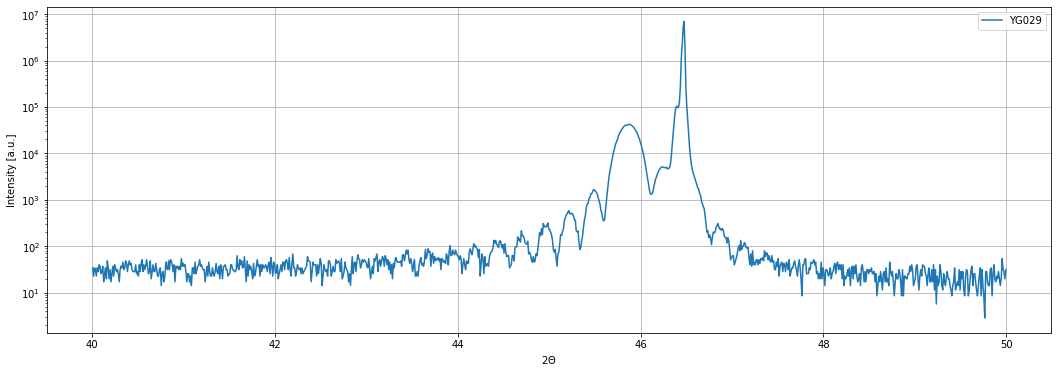

2.1999999999999886e-01


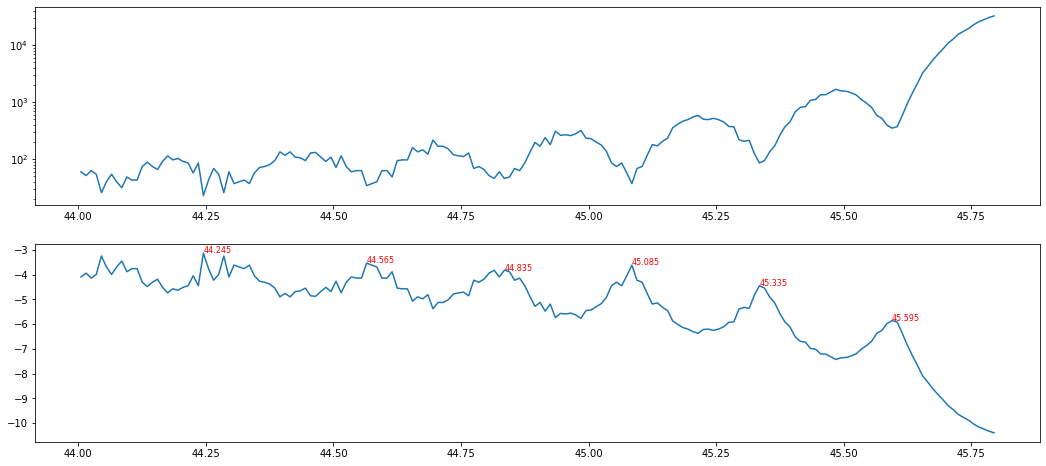

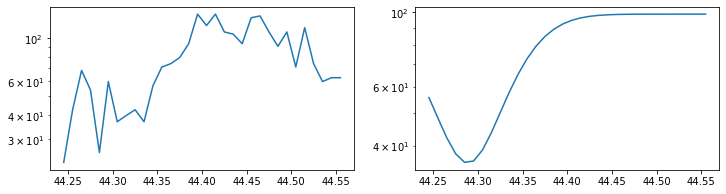


FWHM == sigma*2*sqrt(2*ln(2)): 0.11722107339596122 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 44.395 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


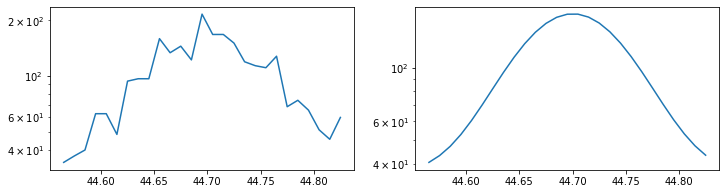


FWHM == sigma*2*sqrt(2*ln(2)): 0.12205146342746888 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 44.695 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


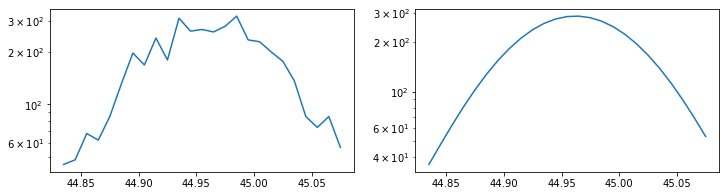


FWHM == sigma*2*sqrt(2*ln(2)): 0.13915996623981305 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 44.985 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


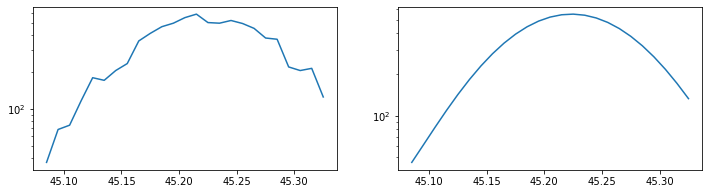


FWHM == sigma*2*sqrt(2*ln(2)): 0.1376987378667462 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 45.215 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


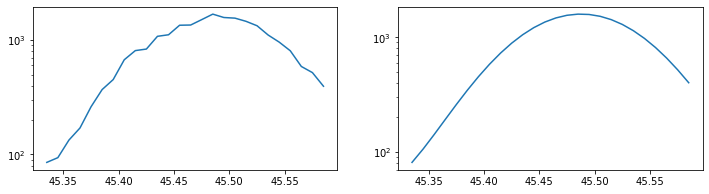


FWHM == sigma*2*sqrt(2*ln(2)): 0.13445832161214474 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 45.485 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))
Sample thickness is 51.63 nm


In [200]:
file = './xrd/set_1/YG030-SRO001-STO001-scan_2-40_50-06072022.xrdml'
x, y = xu.io.getxrdml_scan(file)[:2]
plot_exp_curves([x], [y], labels=['YG029'])

xrange = [44.0, 45.8]
n_peaks = 6
thickness = xrd_thickness(x, y, K, lambdaKa, xrange, n_peaks, show=True)
print('Sample thickness is {:.2f} nm'.format(thickness))

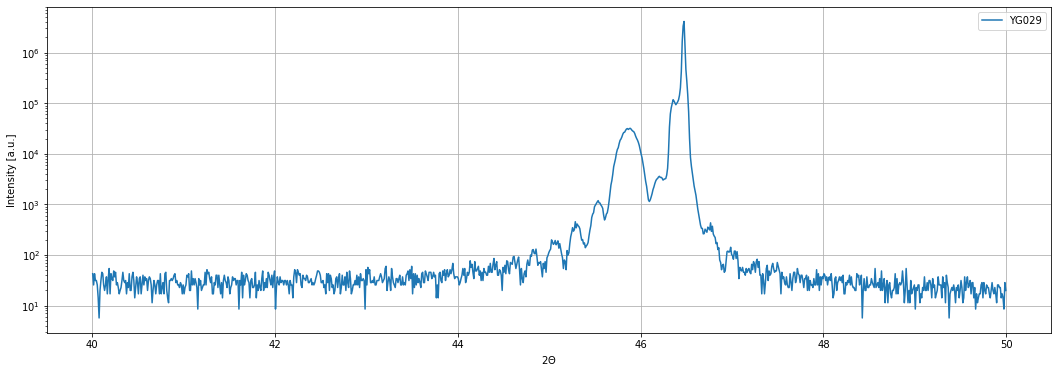

1.599999999999966e-01


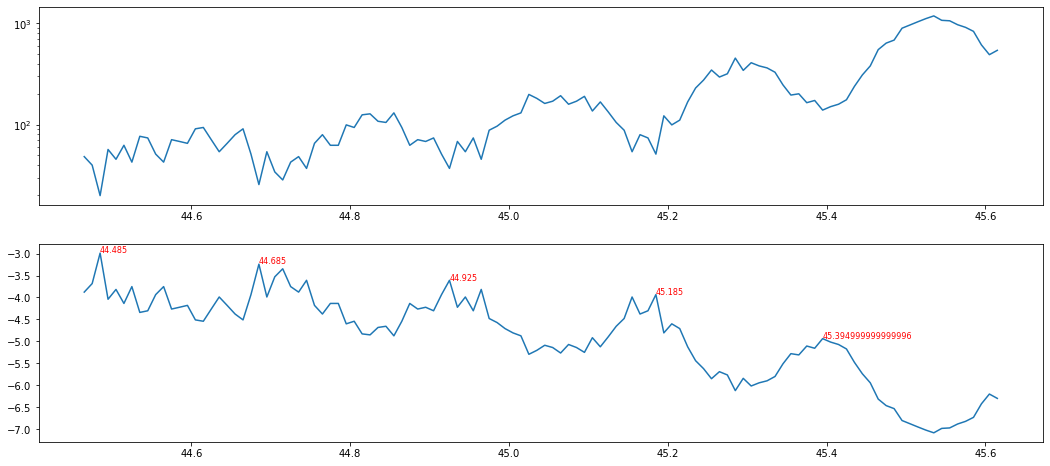

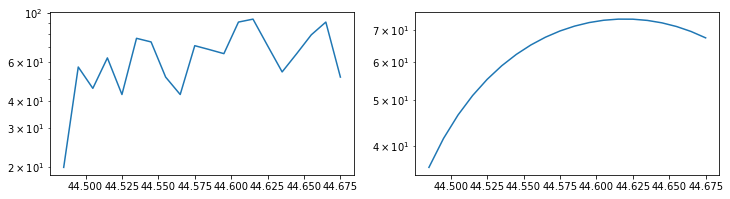


FWHM == sigma*2*sqrt(2*ln(2)): 4.358279354998173 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 44.615 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


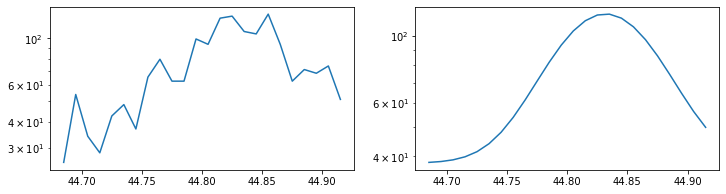


FWHM == sigma*2*sqrt(2*ln(2)): 0.10026025805685346 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 44.855000000000004 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


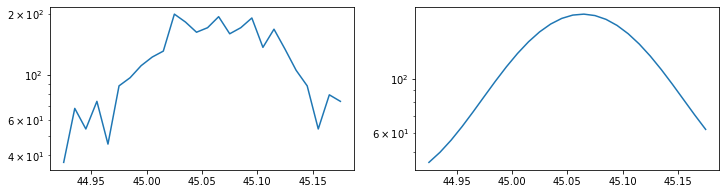


FWHM == sigma*2*sqrt(2*ln(2)): 0.1405746571656336 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 45.025 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


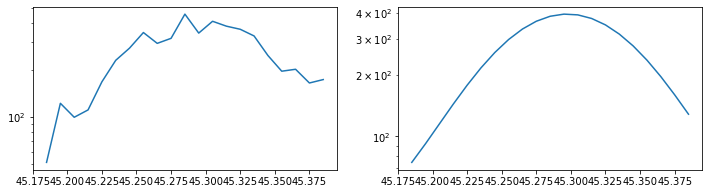


FWHM == sigma*2*sqrt(2*ln(2)): 0.12473056972627593 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 45.285 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))
Sample thickness is 42.36 nm


In [187]:
file = './xrd/set_1/YG029-SRO001-STO001-40_50-scan_3-06052022.xrdml'
x, y = xu.io.getxrdml_scan(file)[:2]
plot_exp_curves([x], [y], labels=['YG029'])

xrange = [44.46, 45.62]
n_peaks = 5
thickness = xrd_thickness(x, y, K, lambdaKa, xrange, n_peaks, show=True)
print('Sample thickness is {:.2f} nm'.format(thickness))

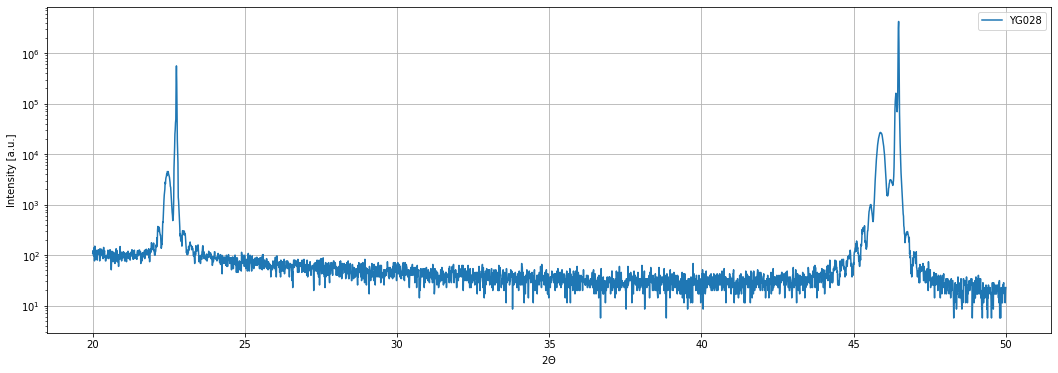

1.4000000000000057e-01


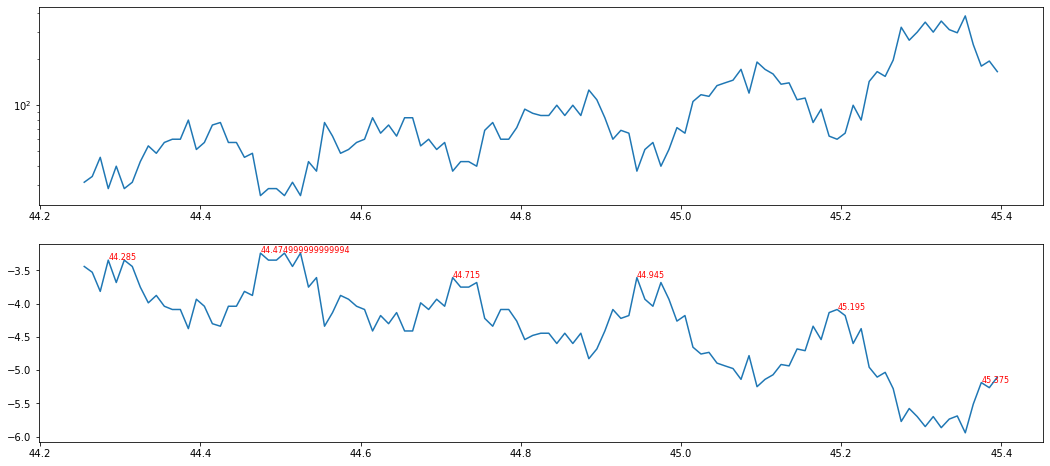

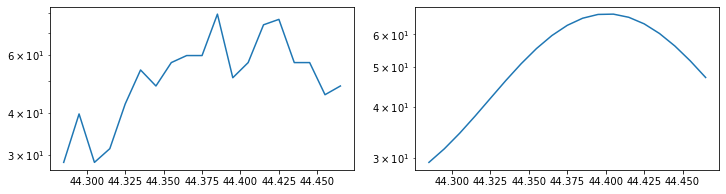


FWHM == sigma*2*sqrt(2*ln(2)): 0.13598620877343398 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 44.385 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


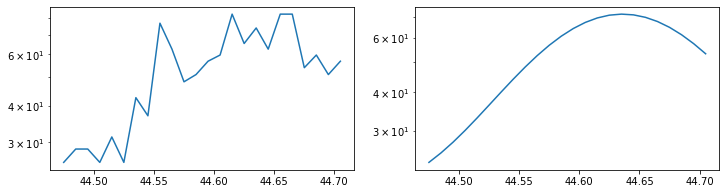


FWHM == sigma*2*sqrt(2*ln(2)): 0.17769449932084022 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 44.614999999999995 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


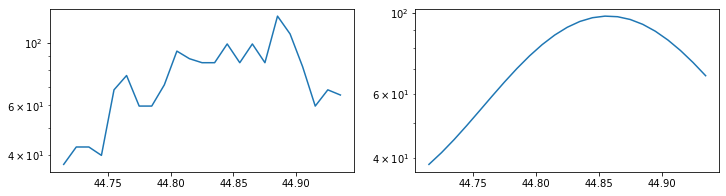


FWHM == sigma*2*sqrt(2*ln(2)): 0.16891903066433697 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 44.885 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


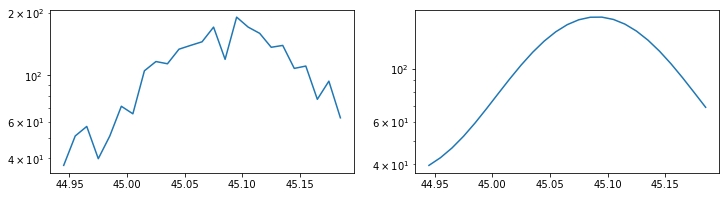


FWHM == sigma*2*sqrt(2*ln(2)): 0.1379126728831756 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 45.095 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))


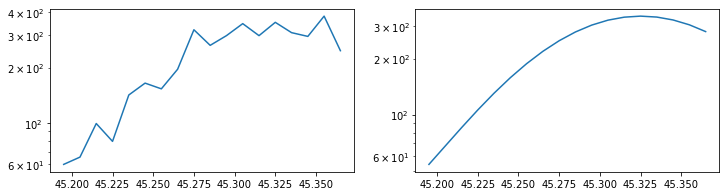


FWHM == sigma*2*sqrt(2*ln(2)): 0.146896618187703 degrees
K (shape factor): 0.7
K-alpha: 0.154056 nm 
max 2-theta: 45.355000000000004 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))
Sample thickness is 44.07 nm


In [175]:
file = './xrd/set_1/YG028-SRO001-STO001-06022022.xrdml'
x, y = xu.io.getxrdml_scan(file)[:2]
plot_exp_curves([x], [y], labels=['YG028'])

xrange = [44.25, 45.4]
n_peaks=5
thickness = xrd_thickness(x, y, K, lambdaKa, xrange, n_peaks, show=True)
print('Sample thickness is {:.2f} nm'.format(thickness))

In [27]:
# get the data in xrange
xrange = [44.25, 45.4]
x_in_range, y_in_range = [],[]
for n in x:
    if n >= xrange[0] and  n <= xrange[1]:
        x_in_range.append(n)
        y_in_range.append(y[list(x).index(n)])

19.166666666666668


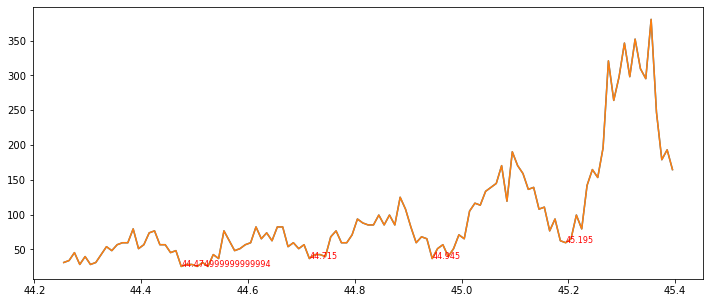

In [28]:
# cut the data into multiple curves

# peaks_1 = signal.argrelextrema(np.array(y_in_range), np.less, order=4)[0]
# peaks_1
n_peaks = 5
dist = len(y_in_range)/(n_peaks+1)
print(dist)

# y_in_range_filtered = signal.medfilt(y_in_range, kernel_size=11)
y_in_range_filtered = np.copy(y_in_range)

peaks, properties = signal.find_peaks(-y_in_range_filtered, prominence=0.2, distance=dist)

plt.figure(figsize=(12,5))
plt.plot(x_in_range, y_in_range)
plt.plot(x_in_range, y_in_range_filtered)
for x, y in zip(np.array(x_in_range)[peaks], np.array(y_in_range)[peaks]):
    pl.text(x, y, str(x), color="red", fontsize=8)
plt.show()

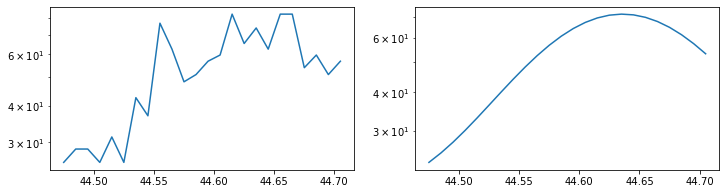

Scherrer Width == K*lmda / (FWHM*cos(theta))


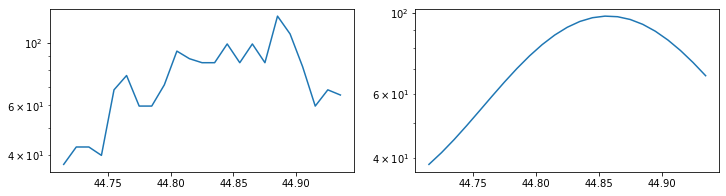

Scherrer Width == K*lmda / (FWHM*cos(theta))


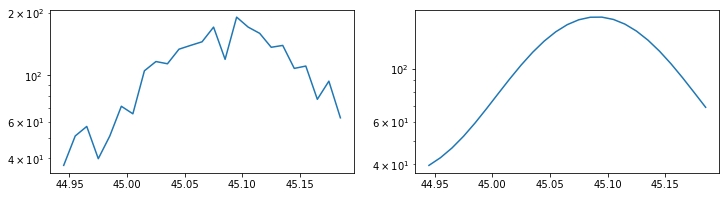

Scherrer Width == K*lmda / (FWHM*cos(theta))
5.3858402106503775e+01 nm


In [29]:
xseg_list, yseg_list = [], []
for i in range(len(peaks[:-1])):
    xseg_list.append(x_in_range[peaks[i]:peaks[i+1]])
    yseg_list.append(y_in_range[peaks[i]:peaks[i+1]])
    
s_list = []
for xseg, yseg in zip(xseg_list, yseg_list):
    s_list.append(xrd_width(xseg, yseg, lambdaKa))
print(np.mean(s_list), 'nm')

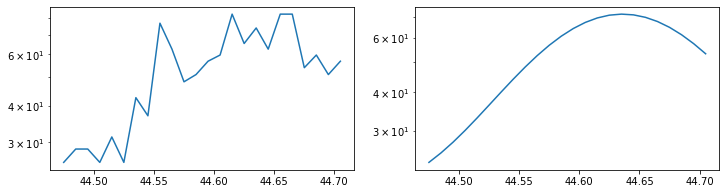

Scherrer Width == K*lmda / (FWHM*cos(theta))


53.692101142320084

In [14]:
    y0,a,mean,sigma = gaussfit(xseg,yseg)
    ysegfit = funcgauss(np.array(xseg),y0,a,mean,sigma)
    
    if show:
        fig, axes = plt.subplots(1, 2, figsize=(12, 3))
        axes[0].plot(xseg, yseg)
        axes[0].semilogy()
        axes[1].plot(xseg, ysegfit)
        axes[1].semilogy()
        plt.show()
    
    'FULL WIDTH AT HALF MAXIMUM'
    FWHM_deg = sigma*2*np.sqrt(2*np.log(2))
    FWHM = FWHM_deg*np.pi/180
#     print('\nFWHM == sigma*2*sqrt(2*ln(2)): {} degrees'.format(FWHM_deg))

    'scherrer width peak calculations'
    max_twotheta = xseg[list(yseg).index(max(yseg))]

    theta=max_twotheta/2
    theta=theta*np.pi/180

#     print('K (shape factor): {}\nK-alpha: {} nm \nmax 2-theta: {} degrees'.\
#           format(K,lambdaKa,max_twotheta))
    
    s=scherrer(K,lambdaKa,FWHM,theta)
    s

In [ ]:
xseg, yseg = 

In [ ]:
xrd_width(x_in_range_list[i], y_in_range_list[i], lambdaKa)

In [ ]:
    y0,a,mean,sigma = gaussfit(xseg,yseg)
    ysegfit = funcgauss(np.array(xseg),y0,a,mean,sigma)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(xseg, yseg)
    axes[0].semilogy()
    axes[1].plot(xseg, ysegfit)
    axes[1].semilogy()
    plt.show()
    
    'FULL WIDTH AT HALF MAXIMUM'
    FWHM_deg = sigma*2*np.sqrt(2*np.log(2))
    FWHM = FWHM_deg*np.pi/180
#     print('\nFWHM == sigma*2*sqrt(2*ln(2)): {} degrees'.format(FWHM_deg))

    'scherrer width peak calculations'
    max_twotheta = xseg[list(yseg).index(max(yseg))]

    theta=max_twotheta/2
    theta=theta*np.pi/180

#     print('K (shape factor): {}\nK-alpha: {} nm \nmax 2-theta: {} degrees'.\
#           format(K,lambdaKa,max_twotheta))
    
    s=scherrer(K,lambdaKa,FWHM,theta)

In [6]:
peaks_1, properties

(array([ 13,  40,  63,  84, 110]),
 {'prominences': array([ 51.13636364,  45.45454545,  88.06818182, 130.68181818,
         215.90909091]),
  'left_bases': array([ 5, 27, 27, 27, 27]),
  'right_bases': array([ 22,  46,  69,  94, 114])})

In [7]:
    'FULL WIDTH AT HALF MAXIMUM'
    FWHM_deg = sigma*2*np.sqrt(2*np.log(2))
    FWHM = FWHM_deg*np.pi/180
    print('\nFWHM == sigma*2*sqrt(2*ln(2)): {} degrees'.format(FWHM_deg))

    'scherrer width peak calculations'
    max_twotheta = xseg[list(yseg).index(max(yseg))]

    theta=max_twotheta/2
    theta=theta*np.pi/180

    print('K (shape factor): {}\nK-alpha: {} nm \nmax 2-theta: {} degrees'.\
          format(K,lambdaKa,max_twotheta))
    
    s=scherrer(K,lambdaKa,FWHM,theta)
    X,Y = xseg,ysegfit

NameError: name 'sigma' is not defined

In [49]:
def xrd_width(xseg, yseg, lambdaKa):
    y0,a,mean,sigma = gaussfit(xseg,yseg)
    ysegfit = funcgauss(np.array(xseg),y0,a,mean,sigma)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(xseg, yseg)
    axes[0].semilogy()
    axes[1].plot(xseg, ysegfit)
    axes[1].semilogy()
    plt.show()
    
    'FULL WIDTH AT HALF MAXIMUM'
    FWHM_deg = sigma*2*np.sqrt(2*np.log(2))
    FWHM = FWHM_deg*np.pi/180
#     print('\nFWHM == sigma*2*sqrt(2*ln(2)): {} degrees'.format(FWHM_deg))

    'scherrer width peak calculations'
    max_twotheta = xseg[list(yseg).index(max(yseg))]

    theta=max_twotheta/2
    theta=theta*np.pi/180

#     print('K (shape factor): {}\nK-alpha: {} nm \nmax 2-theta: {} degrees'.\
#           format(K,lambdaKa,max_twotheta))
    
    s=scherrer(K,lambdaKa,FWHM,theta)
    return s

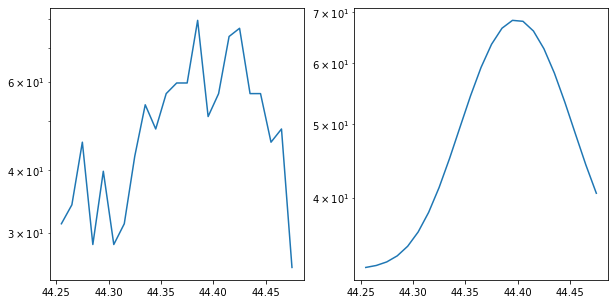

Scherrer Width == K*lmda / (FWHM*cos(theta))


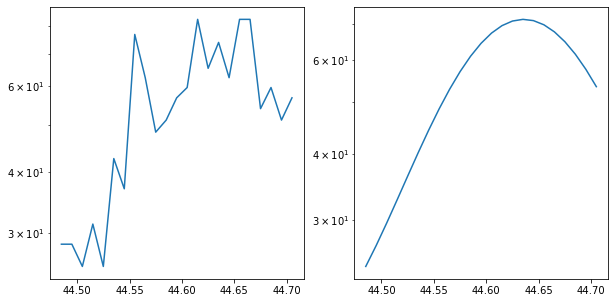

Scherrer Width == K*lmda / (FWHM*cos(theta))


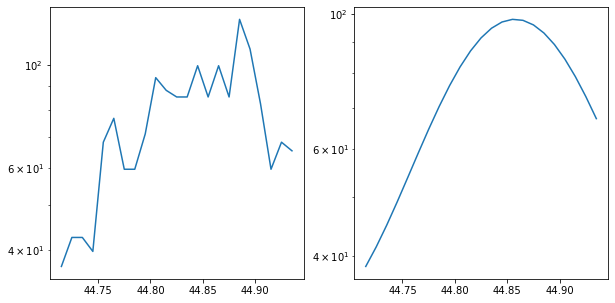

Scherrer Width == K*lmda / (FWHM*cos(theta))


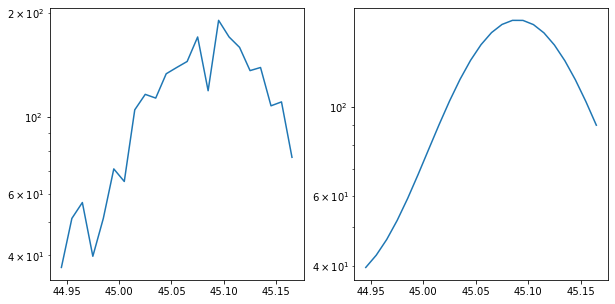

Scherrer Width == K*lmda / (FWHM*cos(theta))


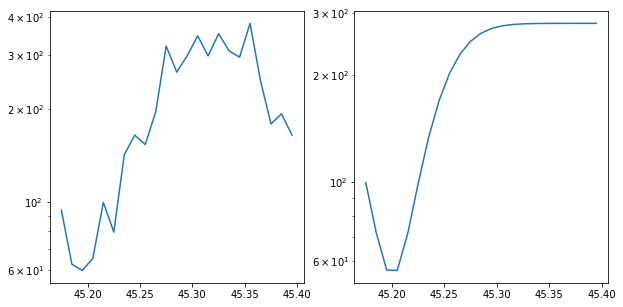

Scherrer Width == K*lmda / (FWHM*cos(theta))
7.567215913146813e+01 nm


In [51]:
x_in_range_list = []
start = 0
for i in range(n_peaks):
    x_in_range_list.append(x_in_range[start: start+len(x_in_range)//5])
    start += len(x_in_range)//5
    
y_in_range_list = []
start = 0
for i in range(n_peaks):
    y_in_range_list.append(y_in_range[start: start+len(y_in_range)//5])
    start += len(y_in_range)//5
    
s_list = []
for i in range(n_peaks):
    s_list.append(xrd_width(x_in_range_list[i], y_in_range_list[i], lambdaKa))
print(np.mean(s_list), 'nm')

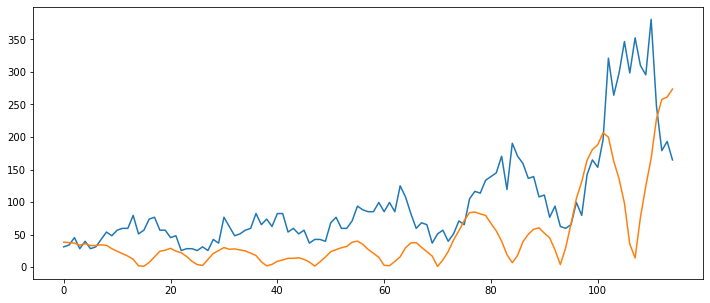

In [21]:
# # peaks_1 = signal.argrelextrema(np.array(y_in_range), np.less, order=4)[0]
# # peaks_1
# dist = len(y_in_range)/n_peaks+2

# sound = np.copy(y_in_range)
# step_size = 10
# step = np.hstack((np.ones(step_size), -1*np.ones(step_size)))
# dary_step = np.convolve(sound, step, mode='same')
# dary_step = np.abs(dary_step)

# filtered_sound = dary_step/step_size

# peaks_1, properties = signal.find_peaks(dary_step, prominence=1, distance=dist)
# plt.figure(figsize=(12,5))
# plt.plot(sound)
# plt.plot(filtered_sound)
# plt.show()# peaks_1, properties = signal.find_peaks(y_in_range, prominence=1, distance=dist)

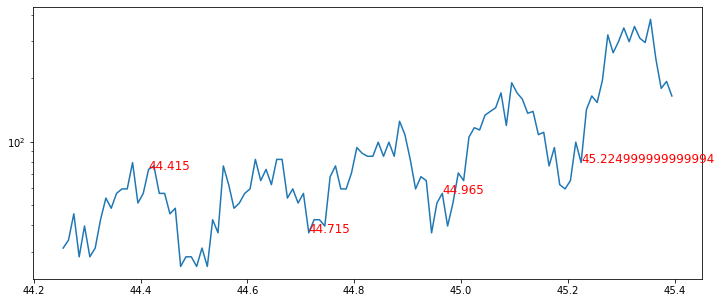

In [15]:
%matplotlib inline
plt.figure(figsize=(12,5))
plt.plot(x_in_range, y_in_range)
for x, y in zip(np.array(x_in_range)[peaks_1], np.array(y_in_range)[peaks_1]):
    pl.text(x, y, str(x), color="red", fontsize=12)
plt.semilogy()
plt.show()

In [ ]:
peaks, properties = signal.find_peaks(y_in_range, prominence=0.2, distance=dist)
peaks_1 = signal.argrelextrema(sound_1, np.greater, order=100)[0]

In [83]:
n_peaks = 5

In [91]:
x_in_range_list = []
start = 0
for i in range(n_peaks):
    x_in_range_list.append(x_in_range[start: start+len(x_in_range)//5])
    start += len(x_in_range)//5
    
y_in_range_list = []
start = 0
for i in range(n_peaks):
    y_in_range_list.append(y_in_range[start: start+len(y_in_range)//5])
    start += len(y_in_range)//5

In [93]:
len(y_in_range_list)

5

In [88]:
def xrd_width(xseg, yseg, lambdaKa):
    y0,a,mean,sigma = gaussfit(xseg,yseg)
    ysegfit = funcgauss(np.array(xseg),y0,a,mean,sigma)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(xseg, yseg)
    axes[0].semilogy()
    axes[1].plot(xseg, ysegfit)
    axes[1].semilogy()
    plt.show()
    
    'FULL WIDTH AT HALF MAXIMUM'
    FWHM_deg = sigma*2*np.sqrt(2*np.log(2))
    FWHM = FWHM_deg*np.pi/180
#     print('\nFWHM == sigma*2*sqrt(2*ln(2)): {} degrees'.format(FWHM_deg))

    'scherrer width peak calculations'
    max_twotheta = xseg[list(yseg).index(max(yseg))]

    theta=max_twotheta/2
    theta=theta*np.pi/180

#     print('K (shape factor): {}\nK-alpha: {} nm \nmax 2-theta: {} degrees'.\
#           format(K,lambdaKa,max_twotheta))
    
    s=scherrer(K,lambdaKa,FWHM,theta)
    return s

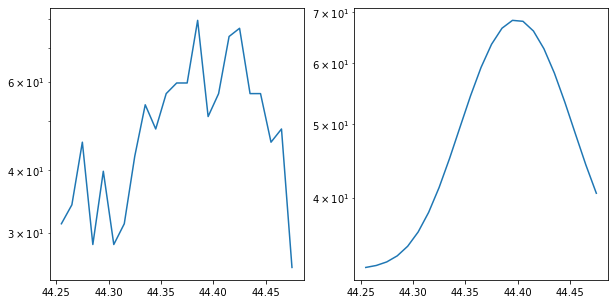

Scherrer Width == K*lmda / (FWHM*cos(theta))


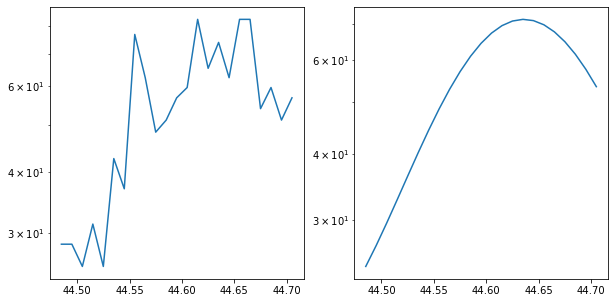

Scherrer Width == K*lmda / (FWHM*cos(theta))


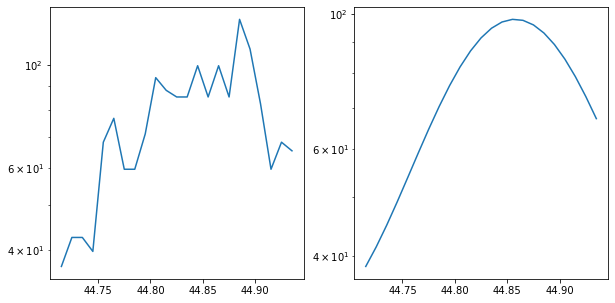

Scherrer Width == K*lmda / (FWHM*cos(theta))


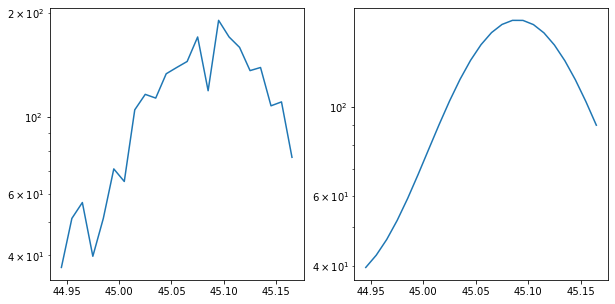

Scherrer Width == K*lmda / (FWHM*cos(theta))


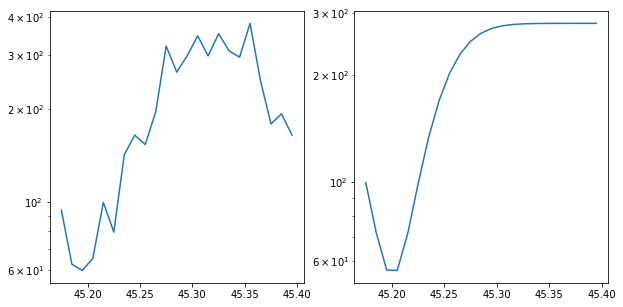

Scherrer Width == K*lmda / (FWHM*cos(theta))
7.567215913146813e+01 nm


In [94]:
s_list = []
for i in range(n_peaks):
    s_list.append(xrd_width(x_in_range_list[i], y_in_range_list[i], lambdaKa))
print(np.mean(s_list), 'nm')

In [ ]:
    'FULL WIDTH AT HALF MAXIMUM'
    FWHM_deg = sigma*2*np.sqrt(2*np.log(2))
    FWHM = FWHM_deg*np.pi/180
    print('\nFWHM == sigma*2*sqrt(2*ln(2)): {} degrees'.format(FWHM_deg))

    'scherrer width peak calculations'
    max_twotheta = xseg[list(yseg).index(max(yseg))]

    theta=max_twotheta/2
    theta=theta*np.pi/180

    print('K (shape factor): {}\nK-alpha: {} nm \nmax 2-theta: {} degrees'.\
          format(K,lambdaKa,max_twotheta))
    
    s=scherrer(K,lambdaKa,FWHM,theta)
    X,Y = xseg,ysegfit
    

In [54]:
    y0,a,mean,sigma = gaussfit(xseg,yseg)
    ysegfit = funcgauss(np.array(xseg),y0,a,mean,sigma)

-Gaussian fit results-
y-shift 76.82368323000986
amplitude 38.99310962433133
mean 45.29853160036559
sigma 0.04879373910708004
covariance matrix 
[[ 1.71742806e+01 -4.32965816e+00  1.03115127e-04 -3.43718688e-03]
 [-4.32965816e+00  5.47988226e+00  5.87521997e-06  4.57724605e-03]
 [ 1.03115127e-04  5.87521997e-06  9.11341260e-06  4.88123558e-08]
 [-3.43718688e-03  4.57724605e-03  4.88123558e-08  9.94906831e-06]]


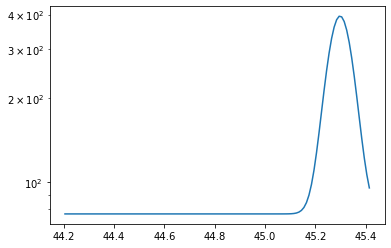

In [56]:
plt.plot(xseg, ysegfit)
plt.semilogy()
plt.show()

In [ ]:
    'FULL WIDTH AT HALF MAXIMUM'
    FWHM_deg = sigma*2*np.sqrt(2*np.log(2))
    FWHM = FWHM_deg*np.pi/180
    print('\nFWHM == sigma*2*sqrt(2*ln(2)): {} degrees'.format(FWHM_deg))

    'scherrer width peak calculations'
    max_twotheta = xseg[list(yseg).index(max(yseg))]

    theta=max_twotheta/2
    theta=theta*np.pi/180

    print('K (shape factor): {}\nK-alpha: {} nm \nmax 2-theta: {} degrees'.\
          format(K,lambdaKa,max_twotheta))
    
    s=scherrer(K,lambdaKa,FWHM,theta)
    X,Y = xseg,ysegfit
    

In [15]:
Y

array([  150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
      

In [12]:
Y.shape

(200,)

In [14]:
X

[44.005,
 44.015,
 44.025,
 44.035,
 44.045,
 44.055,
 44.065,
 44.075,
 44.085,
 44.095,
 44.105000000000004,
 44.115,
 44.125,
 44.135,
 44.145,
 44.155,
 44.165,
 44.175,
 44.185,
 44.195,
 44.205,
 44.215,
 44.225,
 44.235,
 44.245,
 44.255,
 44.265,
 44.275,
 44.285,
 44.295,
 44.305,
 44.315,
 44.325,
 44.335,
 44.345,
 44.355000000000004,
 44.365,
 44.375,
 44.385,
 44.395,
 44.405,
 44.415,
 44.425,
 44.435,
 44.445,
 44.455,
 44.465,
 44.475,
 44.485,
 44.495,
 44.505,
 44.515,
 44.525,
 44.535,
 44.545,
 44.555,
 44.565,
 44.575,
 44.585,
 44.595,
 44.605000000000004,
 44.615,
 44.625,
 44.635,
 44.645,
 44.655,
 44.665,
 44.675,
 44.685,
 44.695,
 44.705,
 44.715,
 44.725,
 44.735,
 44.745,
 44.755,
 44.765,
 44.775,
 44.785,
 44.795,
 44.805,
 44.815,
 44.825,
 44.835,
 44.845,
 44.855000000000004,
 44.865,
 44.875,
 44.885,
 44.895,
 44.905,
 44.915,
 44.925,
 44.935,
 44.945,
 44.955,
 44.965,
 44.975,
 44.985,
 44.995,
 45.005,
 45.015,
 45.025,
 45.035,
 45.045,
 45.055

/home/yichen/anaconda3/envs/gyc/lib/python3.9/site-packages/matplotlib/_api/__init__.py:125: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if val not in values:


ValueError: array([  150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289767,
         150.30289767,   150.30289767,   150.30289767,   150.30289768,
         150.30289769,   150.30289772,   150.30289778,   150.30289792,
         150.30289823,   150.30289889,   150.30290032,   150.30290333,
         150.30290959,   150.30292248,   150.30294865,   150.30300112,
         150.30310498,   150.30330791,   150.30369931,   150.30444453,
         150.30584518,   150.30844382,   150.31320296,   150.32180632,
         150.33715811,   150.36419723,   150.41120403,   150.49186323,
         150.62846695,   150.85680394,   151.23349376,   151.84679443,
         152.83223863,   154.39483137,   156.83994889,   160.6154764 ,
         166.36804658,   175.01640149,   187.84477442,   206.61862861,
         233.72393007,   272.32920927,   326.56684743,   401.72624269,
         504.44681894,   642.89344376,   826.89113386,  1067.99057823,
        1379.43185342,  1775.97175964,  2273.54156127,  2888.70758669,
        3637.9178807 ,  4536.53418973,  5597.66960494,  6830.87698533,
        8240.75975508,  9825.60194379, 11576.13497762, 13474.57111075,
       15494.03420217, 17598.505366  , 19743.37284003, 21876.63304367,
       23940.7360688 , 25875.00852963, 27618.52606397, 29113.25390906,
       30307.23383216, 31157.57513059, 31633.01023905, 31715.8027865 ,
       31402.84578399, 30705.85514309, 29650.64172037, 28275.52494821,
       26629.02398203, 24767.02025175, 22749.62242241, 20637.977845  ,
       18491.26345127, 16364.05645807, 14304.23629848, 12351.51050929]) is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

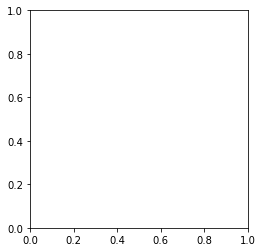

In [12]:
plt.imshow(X, Y)

In [11]:
X

[44.005,
 44.015,
 44.025,
 44.035,
 44.045,
 44.055,
 44.065,
 44.075,
 44.085,
 44.095,
 44.105000000000004,
 44.115,
 44.125,
 44.135,
 44.145,
 44.155,
 44.165,
 44.175,
 44.185,
 44.195,
 44.205,
 44.215,
 44.225,
 44.235,
 44.245,
 44.255,
 44.265,
 44.275,
 44.285,
 44.295,
 44.305,
 44.315,
 44.325,
 44.335,
 44.345,
 44.355000000000004,
 44.365,
 44.375,
 44.385,
 44.395,
 44.405,
 44.415,
 44.425,
 44.435,
 44.445,
 44.455,
 44.465,
 44.475,
 44.485,
 44.495,
 44.505,
 44.515,
 44.525,
 44.535,
 44.545,
 44.555,
 44.565,
 44.575,
 44.585,
 44.595,
 44.605000000000004,
 44.615,
 44.625,
 44.635,
 44.645,
 44.655,
 44.665,
 44.675,
 44.685,
 44.695,
 44.705,
 44.715,
 44.725,
 44.735,
 44.745,
 44.755,
 44.765,
 44.775,
 44.785,
 44.795,
 44.805,
 44.815,
 44.825,
 44.835,
 44.845,
 44.855000000000004,
 44.865,
 44.875,
 44.885,
 44.895,
 44.905,
 44.915,
 44.925,
 44.935,
 44.945,
 44.955,
 44.965,
 44.975,
 44.985,
 44.995,
 45.005,
 45.015,
 45.025,
 45.035,
 45.045,
 45.055

In [10]:
np.sum(X), np.sum(x)

(9000.0, 45000.0)

In [11]:
file = './xrd/set_1/YG029-SRO001-STO001-40_50-scan_3-06052022.xrdml'

out = xu.io.getxrdml_scan(file)
x = out[0]
y = out[1]

s,X,Y = schw_peakcal(x,y,K,lambdaKa,xrange)
print(s)

-Gaussian fit results-
y-shift 150.30289766831825
amplitude 7055.311652793802
mean 45.87208598718804
sigma 0.0891212858396039
covariance matrix 
[[ 5.79053643e+02 -2.57929681e+02  1.53456377e-04 -1.95665030e-03]
 [-2.57929681e+02  7.04215664e+02  1.61584643e-03  7.22525348e-03]
 [ 1.53456377e-04  1.61584643e-03  1.16303199e-07  3.02752388e-08]
 [-1.95665030e-03  7.22525348e-03  3.02752388e-08  1.49796384e-07]]

FWHM == sigma*2*sqrt(2*ln(2)): 0.20986459033403215 degrees
K (shape factor): 1
K-alpha: 0.154056 nm 
max 2-theta: 45.885 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))
45.672128626302054


In [67]:
file = './xrd/set_1/YG030-SRO001-STO001-scan_2-40_50-06072022.xrdml'

out = xu.io.getxrdml_scan(file)
x = out[0]
y = out[1]

s,X,Y = schw_peakcal(x,y,K,lambdaKa,xrange)
print(s)

-Gaussian fit results-
y-shift 199.93841202762272
amplitude 10407.725944772816
mean 45.8668668115504
sigma 0.09742733061111894
covariance matrix 
[[ 1.24284256e+03 -6.07858681e+02  2.40376611e-04 -3.43462498e-03]
 [-6.07858681e+02  1.73030066e+03  3.48926888e-03  1.34332734e-02]
 [ 2.40376611e-04  3.48926888e-03  1.54628593e-07  4.71961520e-08]
 [-3.43462498e-03  1.34332734e-02  4.71961520e-08  2.01748441e-07]]

FWHM == sigma*2*sqrt(2*ln(2)): 0.2294238310569203 degrees
K (shape factor): 1
K-alpha: 1.54056e-10 nm 
max 2-theta: 45.885 degrees
Scherrer Width == K*lmda / (FWHM*cos(theta))
4.177840863211835e-08


In [46]:
# pip install xrayutilities
import numpy as np
import xrayutilities as xu
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_xrd(files, labels, title='XRD result', diff=1e3, save_path=None, marker=None, pad_sequence=[]):
    Xs, Ys = [], []
    length_list = []
    for file in files:
        out = xu.io.getxrdml_scan(file)
        Xs.append(out[0])
        Ys.append(out[1])
        length_list.append(len(out[0]))
        
    if np.mean(length_list) != np.max(length_list):
        if pad_sequence == []:
            print('Different scan ranges, input pad_sequence to pad')
            return 
        else:
            for i in range(len(Ys)):
                Ys[i] = np.pad(Ys[i], pad_sequence[i], mode='median')
    X = Xs[np.argmax(length_list)]
        
    fig, axes = plt.subplots(figsize=(18, 10))
    
    for i, Y in enumerate(Ys):
        Y[Y==0] = 1  # remove all 0 value
        Y = Y * diff**(len(Ys)-i-1)
        axes.plot(X, Y, marker=marker, label=labels[i])
        
    axes.set_xlabel(r"2$\Theta}$", )
    axes.set_ylabel('Intensity [a.u.]')
    axes.legend()
    plt.yscale('log',base=10) 
    plt.xticks(np.arange(18, 52, 1))
    plt.title(title)

    if save_path:
        plt.savefig(save_path, dpi=1200)
    plt.grid()
    plt.show()

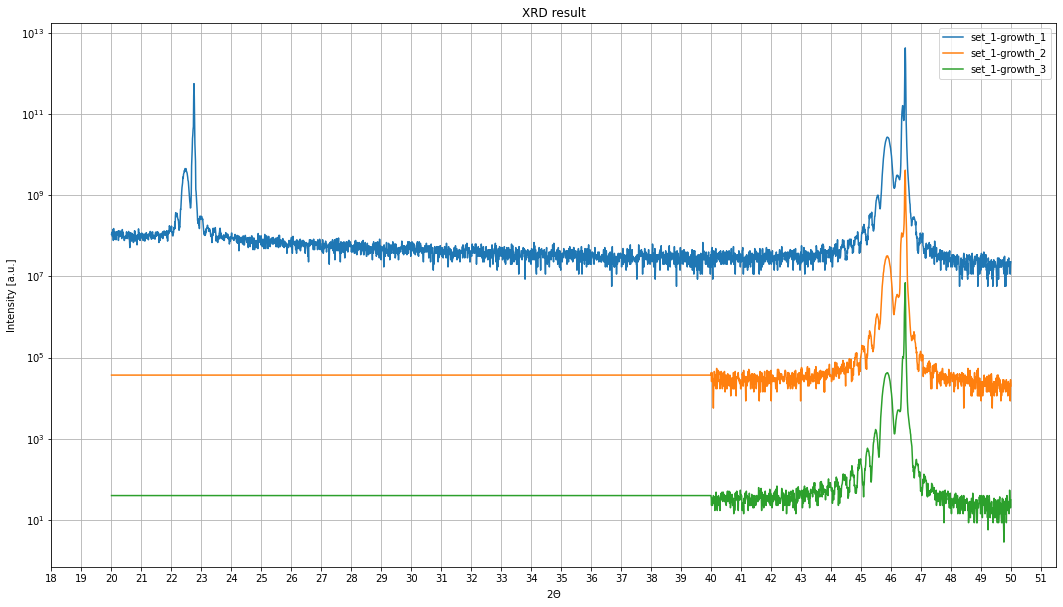

In [47]:
# %matplotlib notebook
%matplotlib inline

files = [
        './xrd/set_1/YG028-SRO001-STO001-06022022.xrdml',
        './xrd/set_1/YG029-SRO001-STO001-40_50-scan_3-06052022.xrdml',
        './xrd/set_1/YG030-SRO001-STO001-scan_2-40_50-06072022.xrdml'
        ]

labels = ['set_1-growth_1', 'set_1-growth_2', 'set_1-growth_3']
plot_xrd(files, labels, diff=1e3, pad_sequence=[(0,0), (2000,0), (2000,0)])
# plot_xrd(files, labels, diff=1e3, pad_sequence=[(0,0), (2000,0), (2000,0)],
#          save_path='./set_1-xrd.png')

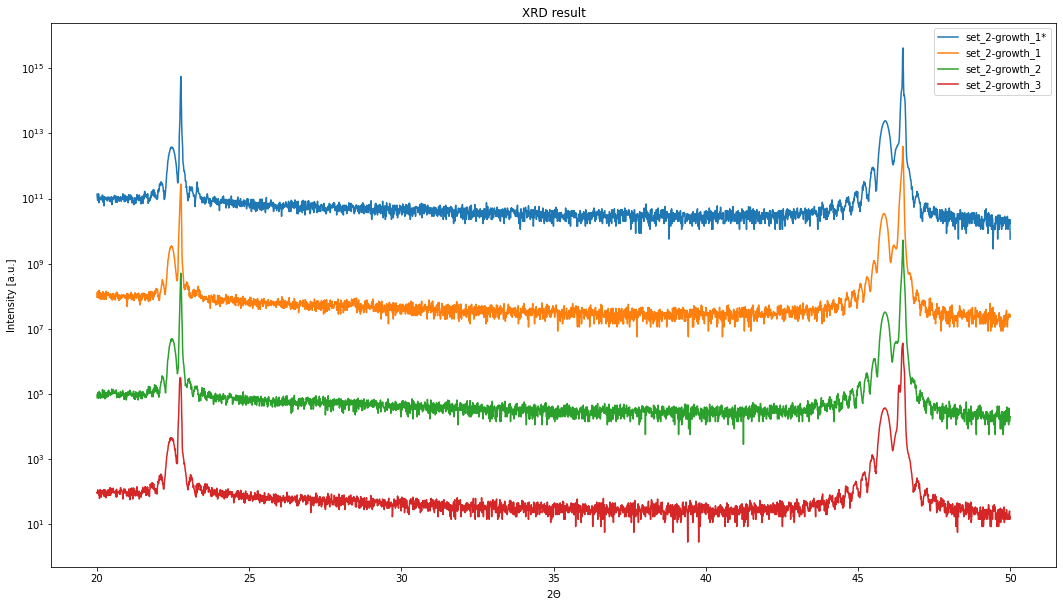

In [107]:
# %matplotlib notebook
%matplotlib inline

files = [
        './xrd/set_2/YG031-SRO001-STO001-06122022.xrdml',
        './xrd/set_2/YG032-SRO001-STO001-06162022.xrdml',
        './xrd/set_2/YG033-SRO001-STO001-06162022.xrdml',
        './xrd/set_2/YG034-SRO001-STO001-06152022.xrdml'
        ]

labels = ['set_2-growth_1*', 'set_2-growth_1', 'set_2-growth_2', 'set_2-growth_3']
plot_xrd(files, labels, diff=1e3, save_path='./set_2-xrd.png')

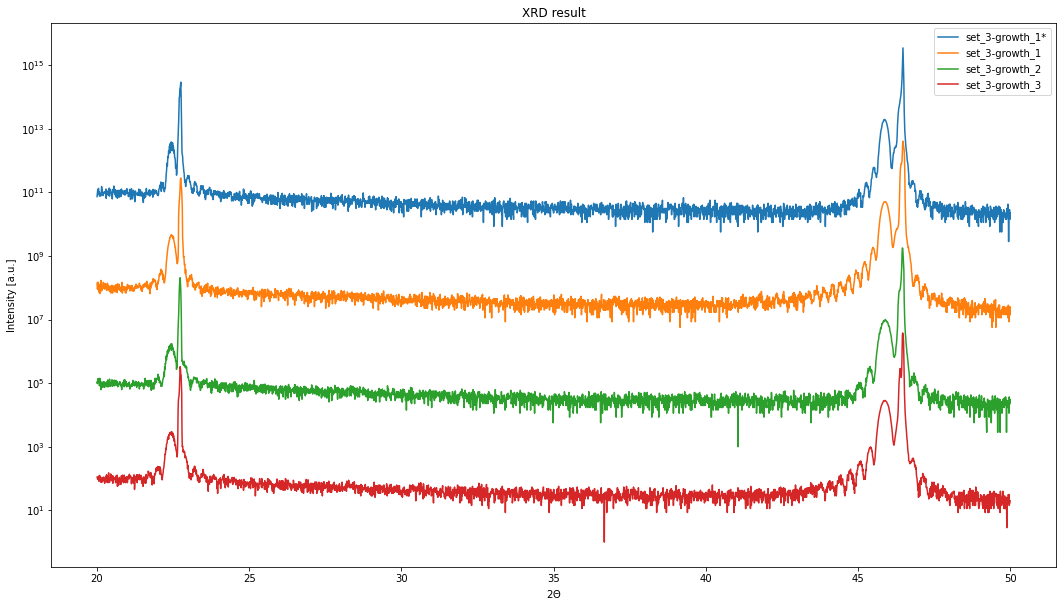

In [108]:
# %matplotlib notebook
%matplotlib inline

files = [
        './xrd/set_3/YG035-SRO001-STO001-06152022.xrdml',
        './xrd/set_3/YG036-SRO001-STO001-06162022.xrdml',
        './xrd/set_3/YG037-SRO001-STO001-06192022.xrdml',
        './xrd/set_3/YG038-SRO001-STO001-06192022.xrdml'
        ]

labels = ['set_3-growth_1*', 'set_3-growth_1', 'set_3-growth_2', 'set_3-growth_3']
plot_xrd(files, labels, diff=1e3, save_path='./set_3-xrd.png')

In [84]:
# pip install xrayutilities
import numpy as np
import xrayutilities as xu
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_xrd(files, labels, title='XRD result', diff=1e3, save_path=None, marker=None):
    Ys = [] 
    for file in files:
        out = xu.io.getxrdml_scan(file)
        X = out[0] 
        Ys.append(np.array(out[1:]).reshape(-1))
        
    fig, axes = plt.subplots(figsize=(18, 10))
    
    for i, Y in enumerate(Ys):
        Y[Y==0] = 1  # remove all 0 value
        Y = Y * diff**(len(Ys)-i-1)
        axes.plot(X, Y, marker=marker, label=labels[i])
        
    axes.set_xlabel(r"2$\Theta}$", )
    axes.set_ylabel('Intensity [a.u.]')
    axes.legend()
    plt.yscale('log',base=10) 
    plt.title(title)

    if save_path:
        plt.savefig(save_path, dpi=1200)
    plt.show()
    
    
    , save_path='./set_2-xrd.png'

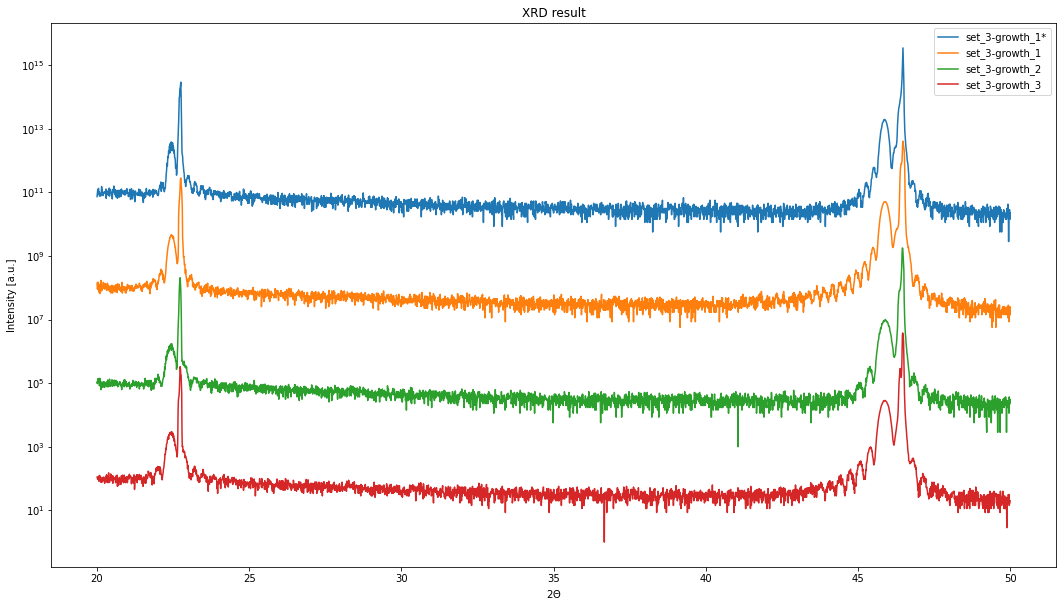

In [85]:
# %matplotlib notebook
%matplotlib inline

files = [
        './xrd/set_3/YG035-SRO001-STO001-06152022.xrdml',
        './xrd/set_3/YG036-SRO001-STO001-06162022.xrdml',
        './xrd/set_3/YG037-SRO001-STO001-06192022.xrdml',
        './xrd/set_3/YG038-SRO001-STO001-06192022.xrdml'
        ]

labels = ['set_3-growth_1*', 'set_3-growth_1', 'set_3-growth_2', 'set_3-growth_3']
plot_xrd(files, labels, diff=1e3, save_path='./set_3-xrd.png')

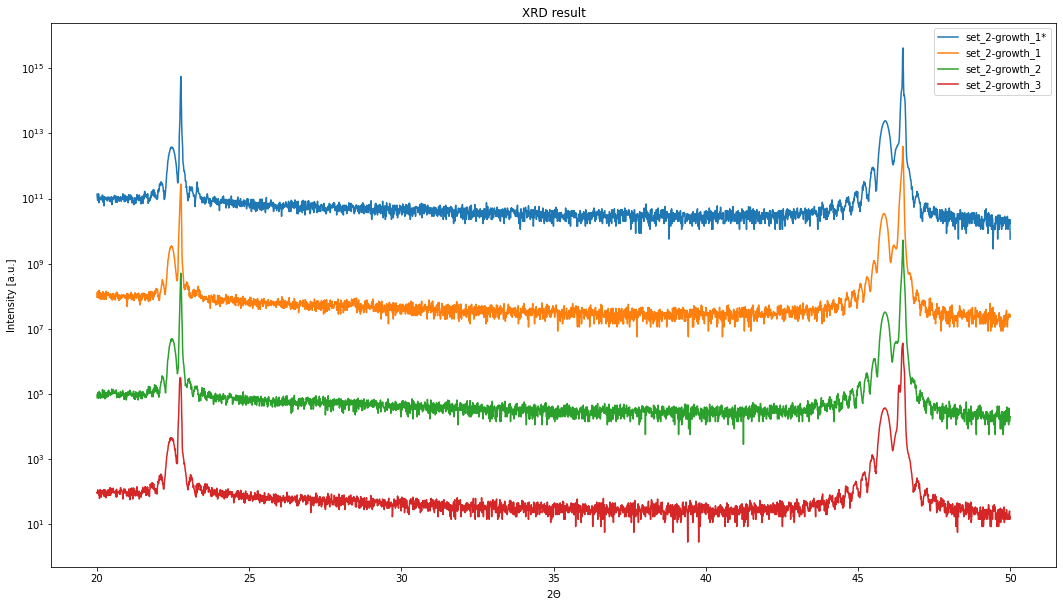

In [86]:
# %matplotlib notebook
%matplotlib inline

files = [
        './xrd/set_2/YG031-SRO001-STO001-06122022.xrdml',
        './xrd/set_2/YG032-SRO001-STO001-06162022.xrdml',
        './xrd/set_2/YG033-SRO001-STO001-06162022.xrdml',
        './xrd/set_2/YG034-SRO001-STO001-06152022.xrdml'
        ]

labels = ['set_2-growth_1*', 'set_2-growth_1', 'set_2-growth_2', 'set_2-growth_3']
plot_xrd(files, labels, diff=1e3, save_path='./set_2-xrd.png')

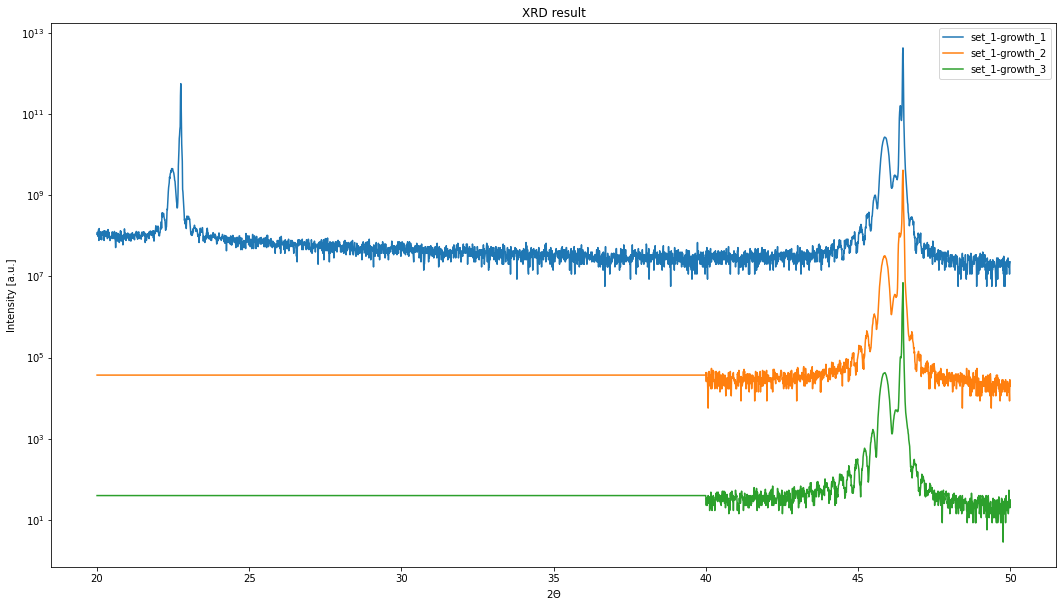

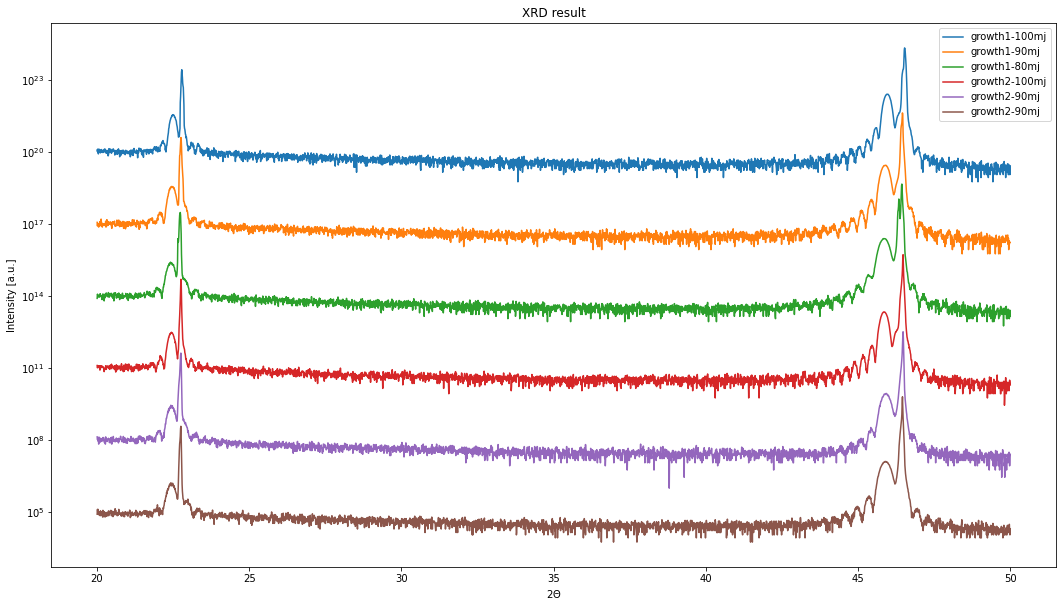

In [20]:
# %matplotlib notebook
%matplotlib inline

files = [
        './xrd/YG021-SRO001-STO001-05252022.xrdml',
        './xrd/YG022-SRO001-STO001-05252022.xrdml',
        './xrd/YG023-SRO001-STO001-05292022-parallel.xrdml',
        './xrd/YG024-SRO001-STO001-05292022.xrdml',
        './xrd/YG025-SRO001-STO001-05302022.xrdml',
        './xrd/YG026-SRO001-STO001-05302022.xrdml'
        ]

labels = ['growth1-100mj', 'growth1-90mj', 'growth1-80mj', 
          'growth2-100mj', 'growth2-90mj', 'growth2-90mj']
plot_xrd(files, labels, diff=1e3)

In [18]:
labels[-]

['growth2-90mj',
 'growth2-90mj',
 'growth2-100mj',
 'growth1-80mj',
 'growth1-90mj',
 'growth1-100mj']

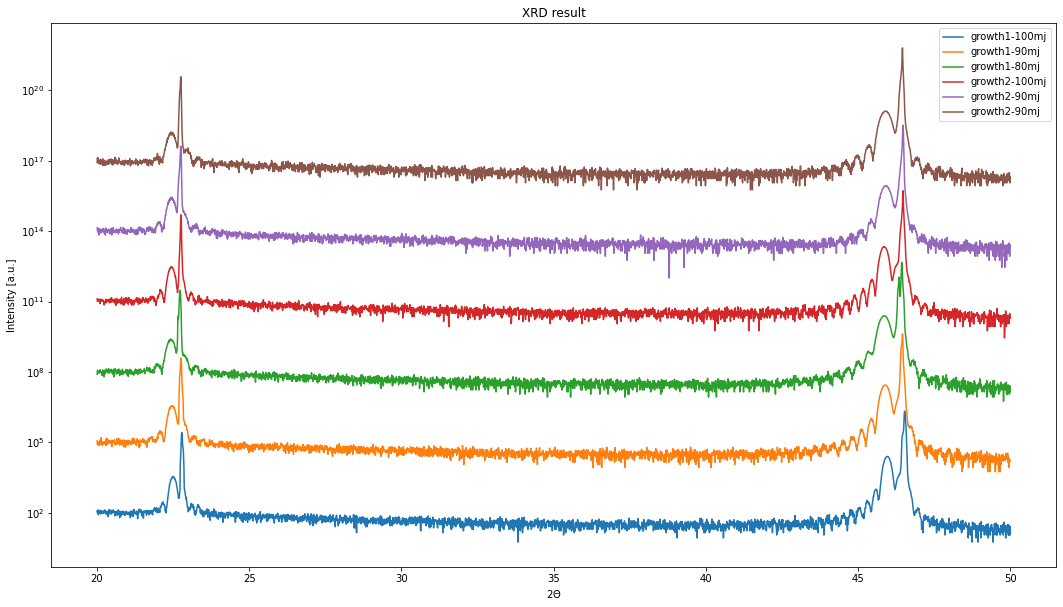

In [16]:
# %matplotlib notebook
%matplotlib inline

files = [
        './xrd/YG021-SRO001-STO001-05252022.xrdml',
        './xrd/YG022-SRO001-STO001-05252022.xrdml',
        './xrd/YG023-SRO001-STO001-05292022-parallel.xrdml',
        './xrd/YG024-SRO001-STO001-05292022.xrdml',
        './xrd/YG025-SRO001-STO001-05302022.xrdml',
        './xrd/YG026-SRO001-STO001-05302022.xrdml'
        ]

labels = ['growth1-100mj', 'growth1-90mj', 'growth1-80mj', 
          'growth2-100mj', 'growth2-90mj', 'growth2-90mj']
plot_xrd(files, labels, diff=1e3)

In [66]:
files = [
        './xrd/set_1/YG028-SRO001-STO001-06022022.xrdml',
        './xrd/set_1/YG029-SRO001-STO001-40_50-scan_3-06052022.xrdml',
        './xrd/set_1/YG030-SRO001-STO001-scan_2-40_50-06072022.xrdml'
        ]

In [39]:
out[0].shape

(1000,)

In [37]:
out[1].shape

(1000,)

In [52]:
    Xs, Ys = [], [] 
    length_list = []
    for file in files:
        out = xu.io.getxrdml_scan(file)
        Xs.append(list(out[0]))
        Ys.append(list(out[1]))
        length_list.append(out[0].shape[0]) 

In [53]:
pad_np=((0,0), (2000,0), (2000,0))

In [61]:
for i in range(len(Ys)):
    Ys[i] = np.pad(Ys[i], pad_np[i], constant_values=1)

In [63]:
Ys = np.stack(Ys)

In [64]:
Ys.shape

(3, 3000)

31


In [71]:
np.mean()

4461.551136363636

In [103]:
# pip install xrayutilities
import numpy as np
import xrayutilities as xu
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_xrd(files, labels, save_path=None, marker=None):
    Ys = [] 
    for file in files:
        out = xu.io.getxrdml_scan(file)

        X = out[0] 
        Ys.append(np.array(out[1:]).reshape(-1))
        
    fig, axes = plt.subplots(len(Ys), 1, figsize=(18, int(3*len(Ys))))
    
    for i, Y in enumerate(Ys):
#         Y = Y + 10**(diff*i+2)
        axes[i].plot(X, Y, marker=marker, label=labels[i])
        axes[i].set_xlabel(r"2$\Theta}$", )
        axes[i].set_ylabel('Intensity [a.u.]')
        axes[i].set_yscale('log',base=10) 
#         axes[i].set_title(labels[i])
        axes[i].set_ylim([1, 1e7])
        
        axes[i].legend(loc='center')
        axes[i].spines['top'].set_visible(False)
#         axes[i].spines['right'].set_visible(False)
#         axes[i].spines['bottom'].set_visible(False)
#         axes[i].spines['left'].set_visible(False)
    fig.tight_layout()
    plt.show()

    if save_path:
        plt.savefig(save_path, dpi=1200)
        plt.show()

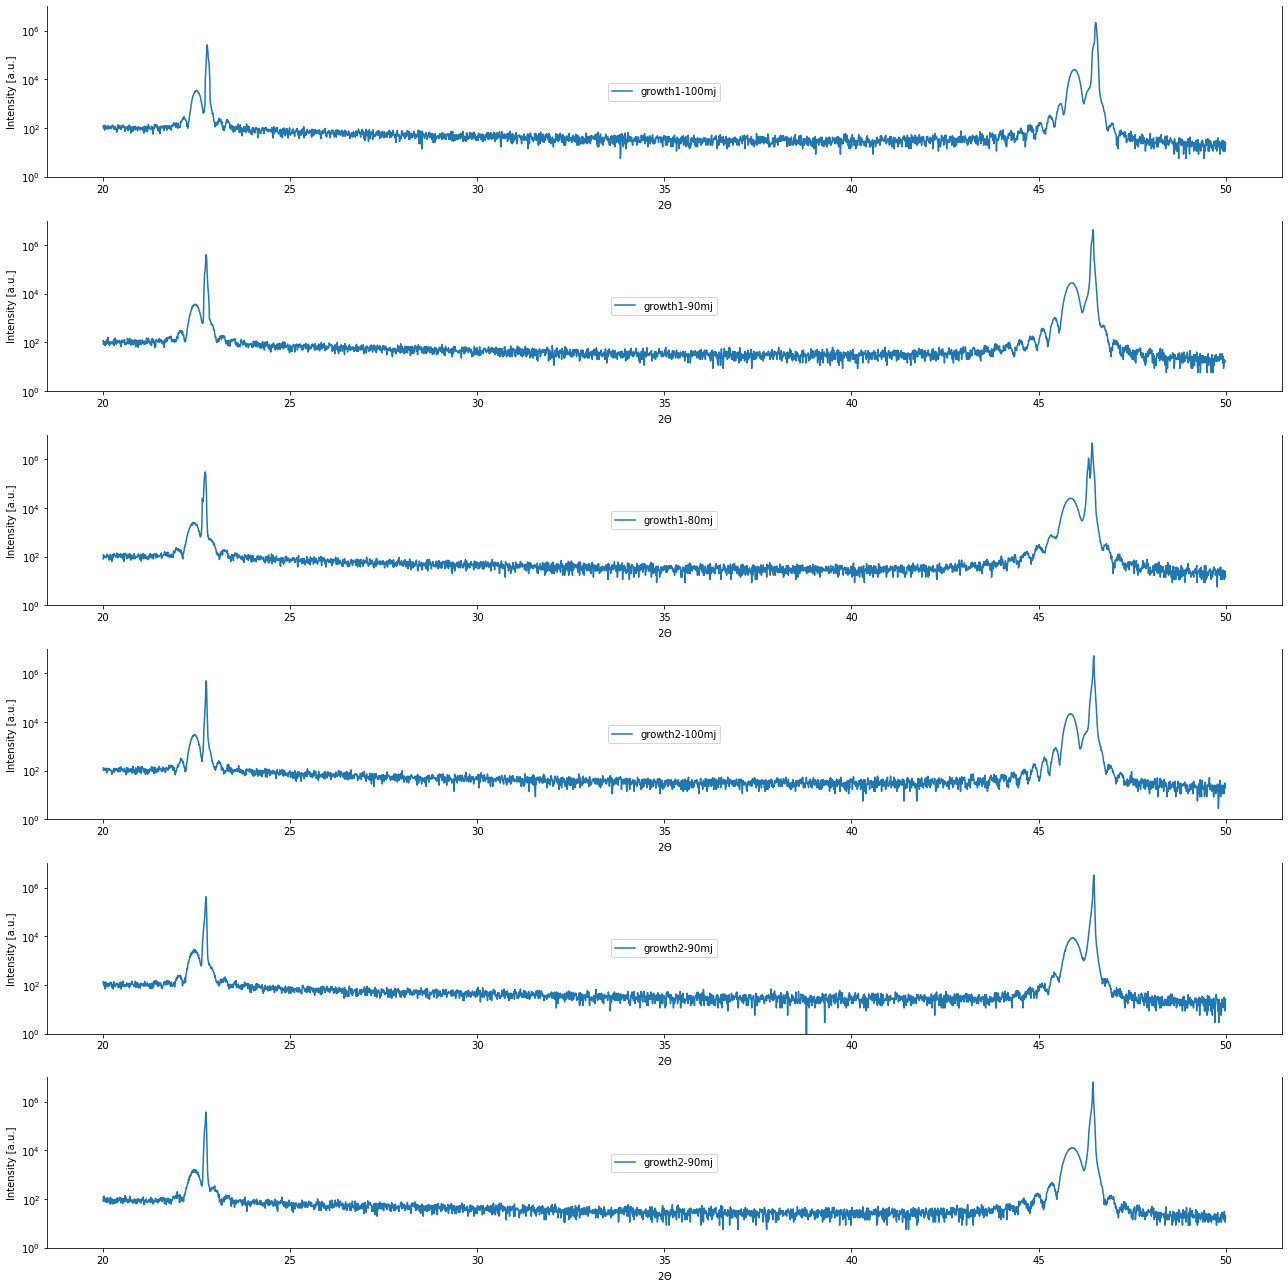

In [104]:
# %matplotlib notebook
%matplotlib inline

files = [
        './xrd/YG021-SRO001-STO001-05252022.xrdml',
        './xrd/YG022-SRO001-STO001-05252022.xrdml',
        './xrd/YG023-SRO001-STO001-05292022-parallel.xrdml',
        './xrd/YG024-SRO001-STO001-05292022.xrdml',
        './xrd/YG025-SRO001-STO001-05302022.xrdml',
        './xrd/YG026-SRO001-STO001-05302022.xrdml',
#         './xrd/YG027-SRO001-STO001-05312022.xrdml',
        ]

labels = ['growth1-100mj', 'growth1-90mj', 'growth1-80mj', 
          'growth2-100mj', 'growth2-90mj', 'growth2-90mj']
plot_xrd(files, labels)

In [106]:
# pip install xrayutilities
import numpy as np
import xrayutilities as xu
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_xrd(files, labels, title='XRD result', diff=1, save_path=None, marker=None):
    Ys = [] 
    for file in files:
        out = xu.io.getxrdml_scan(file)

        X = out[0] 
        Ys.append(np.array(out[1:]).reshape(-1))
        
    fig, axes = plt.subplots(figsize=(18, 10))
    
    for i, Y in enumerate(Ys):
        Y = Y + 10**(diff*i+2)
        axes.plot(X, Y, marker=marker, label=labels[i])
        
    axes.set_xlabel(r"2$\Theta}$", )
    axes.set_ylabel('Intensity [a.u.]')
    axes.legend()
    plt.yscale('log',base=10) 
    plt.title(title)

    if save_path:
        plt.savefig(save_path, dpi=1200)
        plt.show()

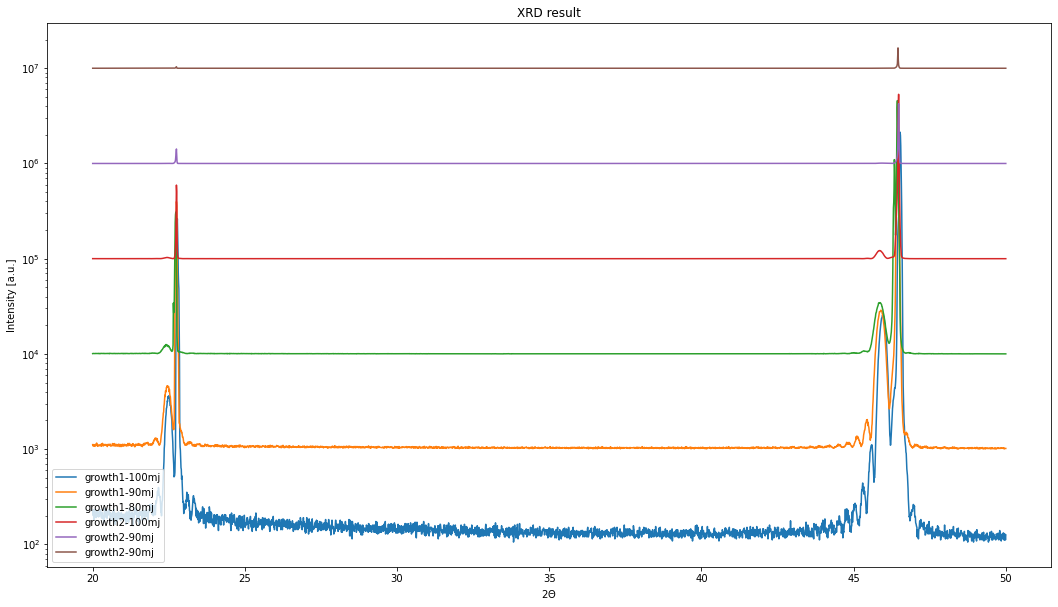

In [107]:
# %matplotlib notebook
%matplotlib inline

files = [
        './xrd/YG021-SRO001-STO001-05252022.xrdml',
        './xrd/YG022-SRO001-STO001-05252022.xrdml',
        './xrd/YG023-SRO001-STO001-05292022-parallel.xrdml',
        './xrd/YG024-SRO001-STO001-05292022.xrdml',
        './xrd/YG025-SRO001-STO001-05302022.xrdml',
        './xrd/YG026-SRO001-STO001-05302022.xrdml',
#         './xrd/YG027-SRO001-STO001-05312022.xrdml',
        ]

labels = ['growth1-100mj', 'growth1-90mj', 'growth1-80mj', 
          'growth2-100mj', 'growth2-90mj', 'growth2-90mj']
plot_xrd(files, labels)

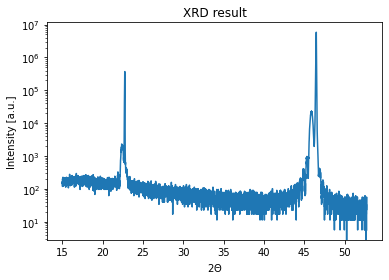

In [4]:
file = './xrd/MA_SRO_STO001_8.xrdml'
plot_xrd(file, save_path=file[:-6]+'.png')

In [56]:
Ys

[[107.95454545454547,
  122.15909090909092,
  105.11363636363637,
  96.5909090909091,
  102.27272727272728,
  142.04545454545456,
  76.70454545454545,
  150.5681818181818,
  82.38636363636364,
  107.95454545454547,
  82.38636363636364,
  125.00000000000001,
  102.27272727272728,
  107.95454545454547,
  99.43181818181819,
  79.54545454545455,
  125.00000000000001,
  119.31818181818183,
  105.11363636363637,
  107.95454545454547,
  127.8409090909091,
  107.95454545454547,
  127.8409090909091,
  76.70454545454545,
  133.52272727272728,
  93.75,
  113.63636363636364,
  116.47727272727273,
  107.95454545454547,
  130.6818181818182,
  110.79545454545455,
  96.5909090909091,
  116.47727272727273,
  119.31818181818183,
  85.22727272727273,
  113.63636363636364,
  142.04545454545456,
  96.5909090909091,
  116.47727272727273,
  122.15909090909092,
  90.90909090909092,
  96.5909090909091,
  76.70454545454545,
  76.70454545454545,
  85.22727272727273,
  88.06818181818183,
  96.5909090909091,
  99.

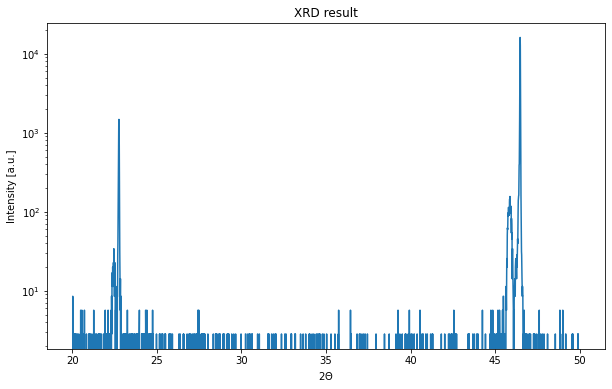

In [2]:
# %matplotlib notebook

file = './xrd/YG004-SRO001-STO001-04232022.xrdml'
plot_xrd(file, save_path=file[:-6]+'.png')

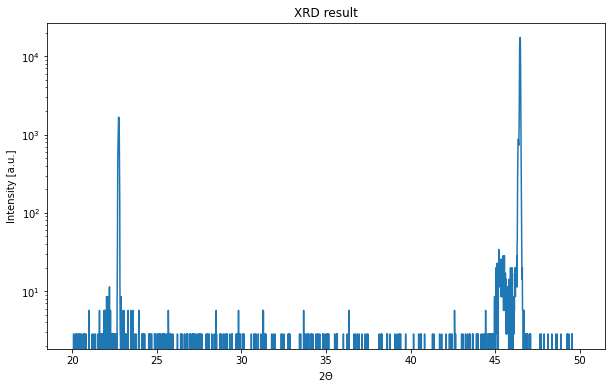

In [3]:
file = './xrd/YG010-SRO001-STO001-04232022.xrdml'
plot_xrd(file, save_path=file[:-6]+'.png')

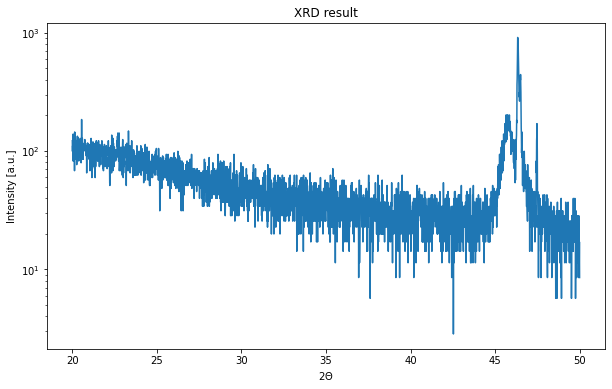

In [4]:
file = './xrd/YG011-SRO001-STO001-04232022.xrdml'
plot_xrd(file, save_path=file[:-6]+'.png')

<IPython.core.display.Javascript object>


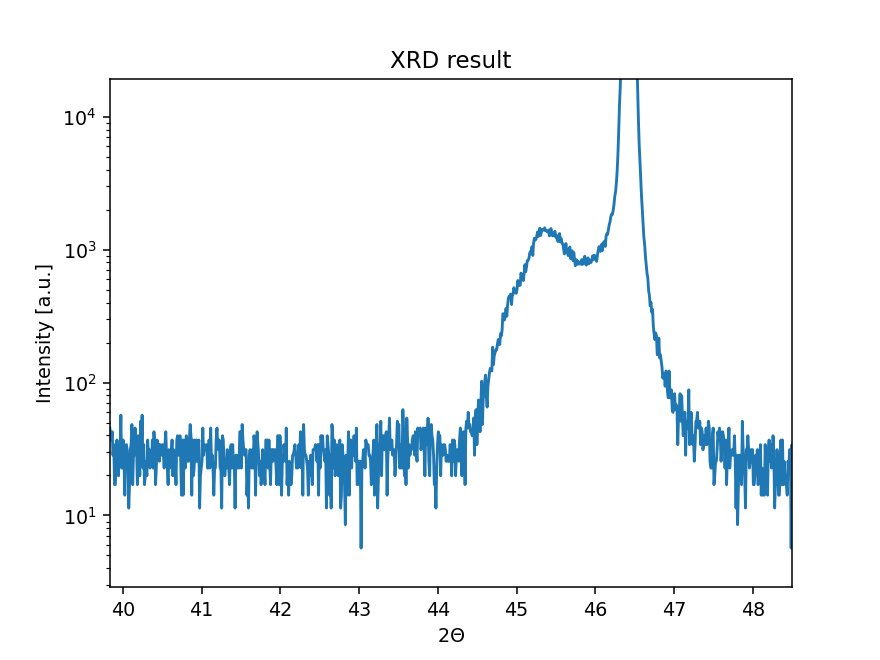

In [13]:
%matplotlib notebook
file = './xrd/YG012-SRO001-STO001-04232022.xrdml'
plot_xrd(file, save_path=file[:-6]+'.png')

<IPython.core.display.Javascript object>


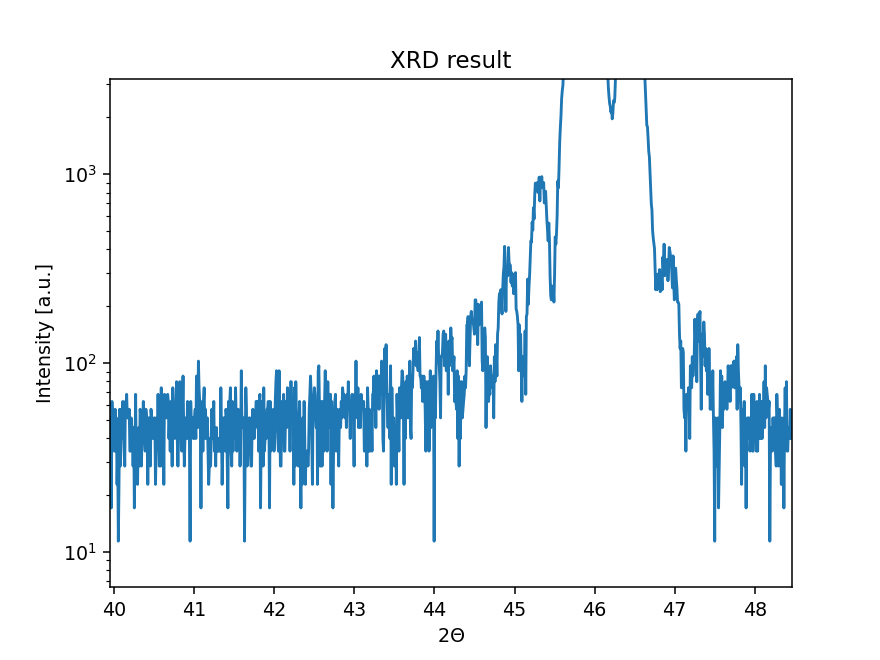

In [14]:
file = './xrd/MA_SRO_STO001_8.xrdml'
plot_xrd(file, save_path=file[:-6]+'.png')

<IPython.core.display.Javascript object>


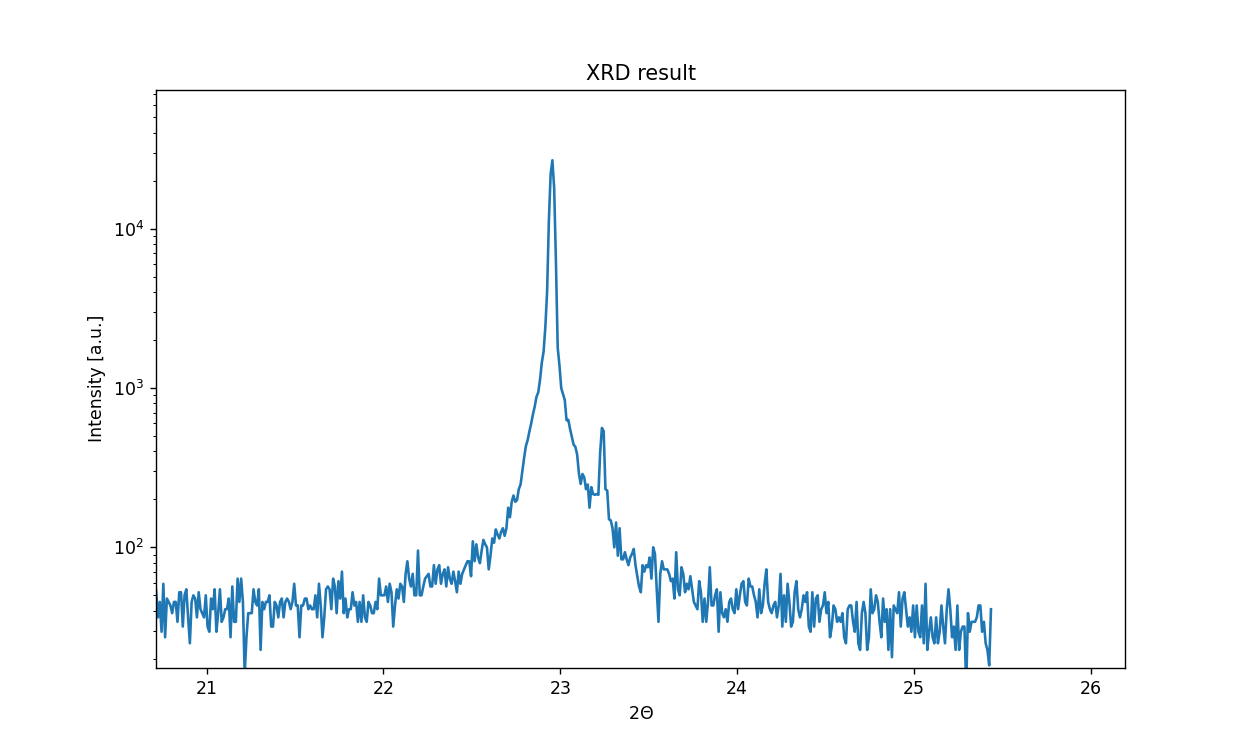

In [6]:
file = './MA_SRO_STO001_8_RC45.8884.xrdml'
plot_xrd(file, save_path=file[:-6]+'.png')

<IPython.core.display.Javascript object>


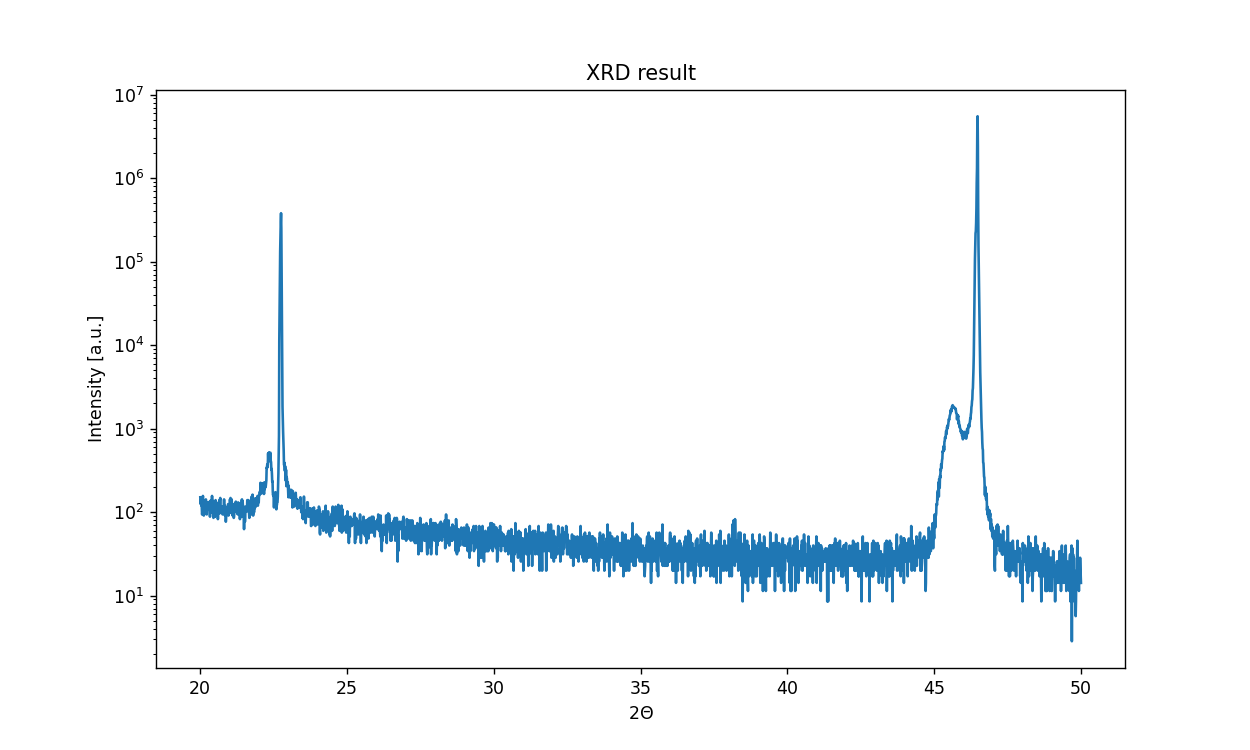

In [12]:
file = './YG003-SRO_001-STO_001-03282022.xrdml'
plot_xrd(file, save_path=file[:-6]+'.png')

# draft

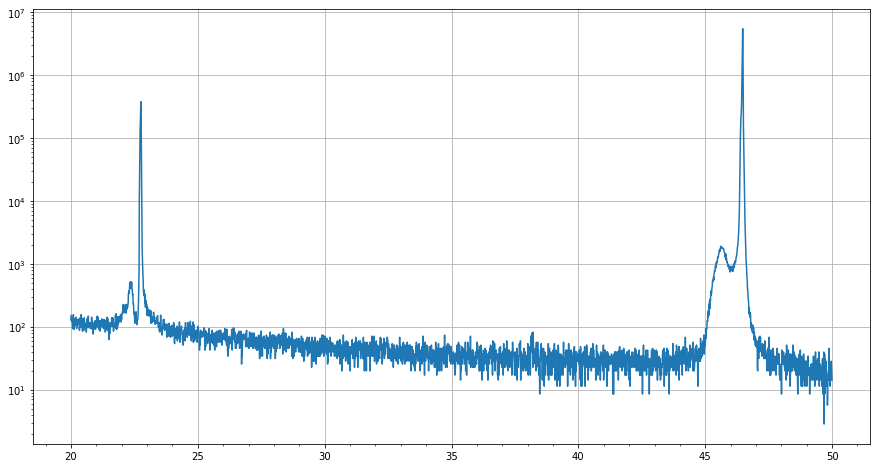

In [73]:
file = './YG003-SRO_001-STO_001-03282022.xrdml'
X = out[0] 
Y = out[1]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(X, Y)

plt.yscale('log',base=10) 

spacing = 1 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)
ax.xaxis.set_minor_locator(minorLocator)

plt.grid()
plt.show()

In [22]:
import matplotlib.pyplot as plt


In [ ]:
xf.scan.

In [18]:
X = xf.scan.ddict['2Theta']
X.shape

(3000,)

In [24]:
Y = xf.scan.ddict['detector']
Y.shape

(3000,)

In [26]:
Y

array([150.56818182, 125.        , 139.20454545, ...,  22.72727273,
        17.04545455,  14.20454545])

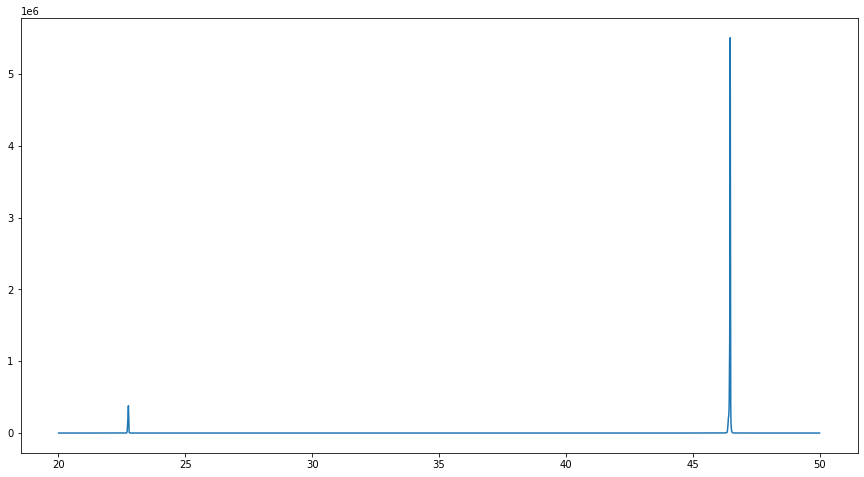

In [27]:
plt.figure(figsize=(15,8))
plt.plot(X, Y)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_xrd(file, title='XRD result', n=1, intensity_difference=500, save_path=None):
    data = pd.read_excel(file, header=29)
    
    X = data['Angle']
    Y = data[' Intensity']
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    
    for i in range(n):
        Y = Y + intensity_difference*i
        plt.plot(X, Y)
        
    plt.title(title)
    ax.set_xlabel(r"2$\Theta}$", )
    ax.set_ylabel('Intensity [a.u.]')

    if save_path:
        plt.savefig(save_path, dpi=1200)
        plt.show()

In [ ]:
# line cut with integration along 2theta to remove beam footprint broadening
qzc, qzint, cmask = xu.analysis.get_radial_scan([qy, qz], psd, [0, 4.5],
                                                1001, 0.155, intdir='2theta')

# line cut with integration along omega
qzc_om, qzint_om, cmask_om = xu.analysis.get_radial_scan([qy, qz], psd, [0, 4.5],
                                                1001, 0.155, intdir='omega')
plt.figure()
plt.semilogy(qzc, qzint, label='Int-dir 2Theta')
plt.semilogy(qzc_om, qzint_om, label='Int-dir Omega')
plt.xlabel(r'scattering angle (deg)')
plt.ylabel(r'intensity (arb. u.)')
plt.legend()
plt.tight_layout()

In [7]:
xf = xu.io.XRDMLFile('./YG003-SRO_001-STO_001-03282022.xrdml')

In [12]:
xf.scan

AttributeError: 'XRDMLMeasurement' object has no attribute 'keys'

In [1]:
import xrdtools

In [3]:
data = xrdtools.read_xrdml('./YG003-SRO_001-STO_001-03282022.xrdml')

ValueError: The file is not conform with hte xrdml schema.

In [4]:
import xrayutilities as xu

ModuleNotFoundError: No module named 'xrayutilities'

In [1]:
! pip install xlrd
! pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_xrd(file, title='XRD result', n=1, intensity_difference=500, save_path=None):
    data = pd.read_excel(file, header=29)
    
    X = data['Angle']
    Y = data[' Intensity']
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    
    for i in range(n):
        Y = Y + intensity_difference*i
        plt.plot(X, Y)
        
    plt.title(title)
    ax.set_xlabel(r"2$\Theta}$", )
    ax.set_ylabel('Intensity [a.u.]')

    if save_path:
        plt.savefig(save_path, dpi=1200)
        plt.show()

In [3]:
file = './YG003-SRO_001-STO_001-03282022.xrdml' # xrd excel file path
save_path = './YG003-SRO_001-STO_001-03282022.svg' # save image file

plot_xrd(file, title='XRD result', n=1, save_path=None)

ValueError: Excel file format cannot be determined, you must specify an engine manually.